# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [2]:
sciper = {'student_1': 281903, 
          'student_2': 281903}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [53]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History, model=""):
    
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.title("Loss training curves: "+model)
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.title("Accuracy training curves: "+model)
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4679/45853 melodies retained


### Solution

In [4]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    tick = 0
    start_tick = dict()
    for event in events:
        tick += event.tick
        if event.name == 'Note On':
            note = event.data[0]
            start_tick[note] = tick
        elif event.name == 'Note Off':
            note = event.data[0]
            P.append(note)
            T.append(tick - start_tick[note] + 1)
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune43726
MIDI events
chorpus/sessiontune43726.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 75 	 Note On 	 105
480 	 75 	 Note Off 	 0
481 	 73 	 Note On 	 80
720 	 73 	 Note Off 	 0
721 	 70 	 Note On 	 80
960 	 70 	 Note Off 	 0
961 	 68 	 Note On 	 95
1200 	 68 	 Note Off 	 0
1201 	 65 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60241 	 68 	 Note On 	 80
60480 	 68 	 Note Off 	 0
60481 	 65 	 Note On 	 95
60720 	 65 	 Note Off 	 0
60721 	 63 	 Note On 	 80
60960 	 63 	 Note Off 	 0
60961 	 63 	 Note On 	 80
61440 	 63 	 Note Off 	 0
########################################

Note representation
{'T': [480, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [5]:
def buildDecoders(dataset):
    pitches = []
    ticks = []
    for label in list(dataset.keys()):
        for pitch in dataset[label]['P']:
            if not pitch in pitches:
                pitches.append(pitch)
        for tick in dataset[label]['T']:
            if not tick in ticks:
                ticks.append(tick)
    decoders = dict()
    decoders['P'] = pitches
    decoders['T'] = ticks
    return decoders    

In [6]:
decoders = buildDecoders(dataset)

In [4]:
def buildEncoder(l):
    encoder = dict()
    for i, v in enumerate(l):
        encoder[v] = i
    return encoder

encoders = dict()
encoders['P'] = buildEncoder(decoders['P'])
encoders['T'] = buildEncoder(decoders['T'])

def translate(melody, dictionaries):
    """ From pitches/ticks to integers"""
    pitches = []
    for p in melody['P']:
        pitches.append(dictionaries['P'][p])
    melody['P'] = pitches
    ticks = []
    for t in melody['T']:
        ticks.append(dictionaries['T'][t])
    melody['T'] = ticks

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("Before encoding")
    print(dataset[label])
    translate(dataset[label], encoders)
    print("After encoding")
    print(dataset[label])
    translate(dataset[label], decoders)
    print("After decoding")
    print(dataset[label])
    print('\n')   

NameError: name 'decoders' is not defined

In [8]:
for label in list(dataset.keys()):
    translate(dataset[label], encoders)

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

In [9]:
def plot_histogram(dataset, key, title):
    """
    plots histogram of values for duration (key='T') or pitch (key='P')
    """
    all_values = []
    for label in dataset:
        all_values.extend(dataset[label][key])
    
    values, counts = np.unique(all_values, return_counts=True)
    print("{} distinct values".format(len(values)))
    plt.bar(values, counts)
    plt.title(title)
    plt.xlabel(key)
    plt.show()

71 distinct values


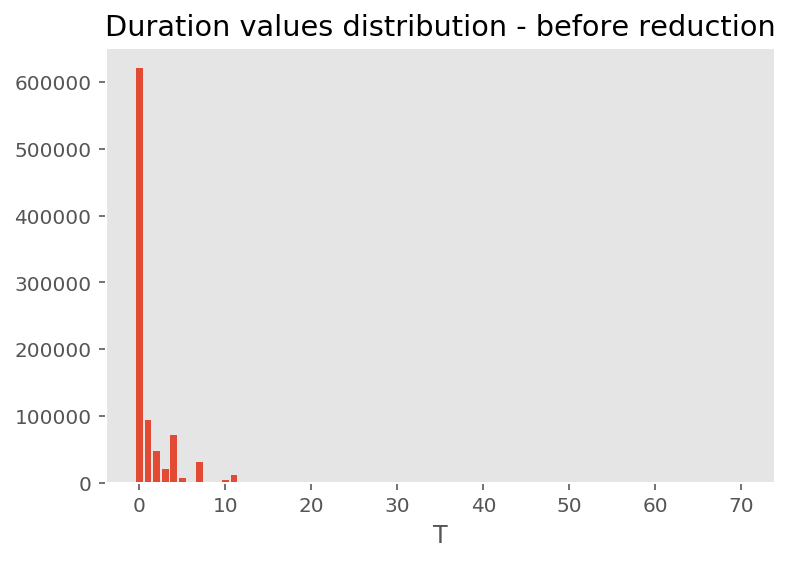

In [10]:
plot_histogram(dataset, 'T', "Duration values distribution - before reduction")

In [11]:
def rare_event_suppression(dataset, decoders, encoders):
    n_values = len(decoders['T'])
    N = len(dataset)
    n_songs = [0]*n_values   # contains the number of songs containing each duration value
    songs_map = dict()  # will map each duration to the songs containing it (max 5% of the dataset)
    
    # find all songs containing rare durations
    for label in dataset:
        values = np.unique(dataset[label]['T'])
        for v in values:
            n_songs[v] += 1
            if v in songs_map and len(songs_map[v]) < 0.05*N:
                songs_map[v].append(label)
            elif v not in songs_map:
                songs_map[v] = [label]
    
    # suppress at most 5% of songs containing rare events
    cont = True
    n_songs_suppressed = 0
    i = 0
    order_of_suppression = np.argsort(n_songs)
    while cont:
        count = 0
        # first count the number of songs that would be suppressed if we eliminate next note
        for label in songs_map[order_of_suppression[i]]:
            if label in dataset:  # if the song has not already been suppressed
                count += 1
        
        # if we are still below 5% of the dataset, proceed to elimination
        if n_songs_suppressed + count < 0.05*N:
            for label in songs_map[order_of_suppression[i]]:
                if label in dataset:  
                    del dataset[label]
                    n_songs_suppressed += 1
        else:
            break
        i += 1
        
    print("{} songs suppressed".format(n_songs_suppressed))
    
    # sadly, we have to go back to original values, or else we will never be able to map back!
    for label in list(dataset.keys()):
        translate(dataset[label], decoders)
    
    # build new decoder/encoder for durations
    newDecoders = buildDecoders(dataset)
    decoders['T'] = newDecoders['T']
    encoders['T'] = buildEncoder(decoders['T'])
    
    # reencode back
    for label in list(dataset.keys()):
        translate(dataset[label], encoders)
    
    plot_histogram(dataset, 'T', "Duration value distribution - after reduction")

214 songs suppressed
17 distinct values


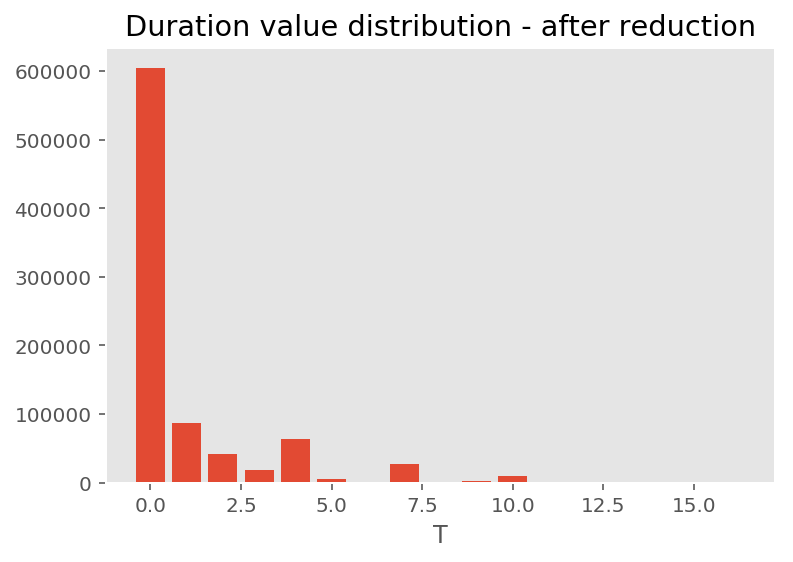

In [12]:
rare_event_suppression(dataset, decoders, encoders)

In [13]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        print(label)
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

47 distinct values


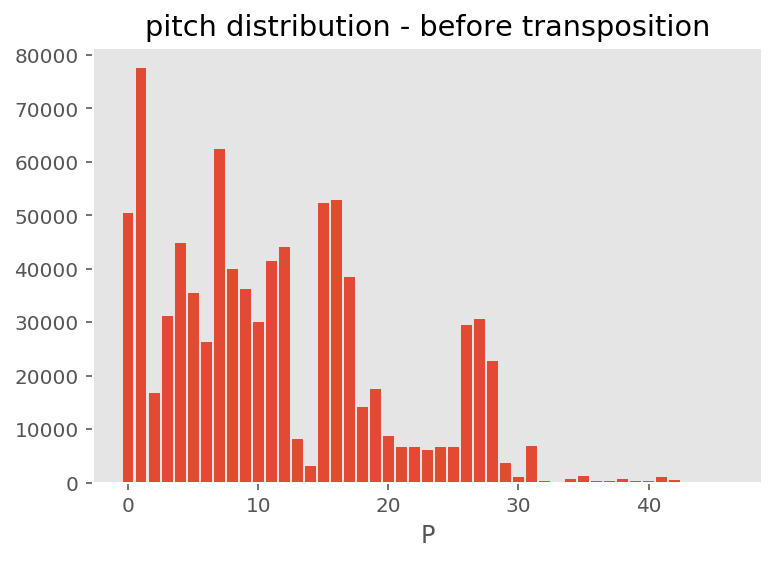

In [14]:
plot_histogram(dataset, 'P', 'pitch distribution - before transposition')

In [ ]:
# get back to original representation
for label in dataset:
    translate(dataset[label], decoders)
    
dataset = transposeDataset(dataset)

# build new decoders
decoders = buildDecoders(dataset)
encoders['P'] = buildEncoder(decoders['P'])

# redo tokenization
for label in dataset:
    translate(dataset[label], encoders)

50 distinct values


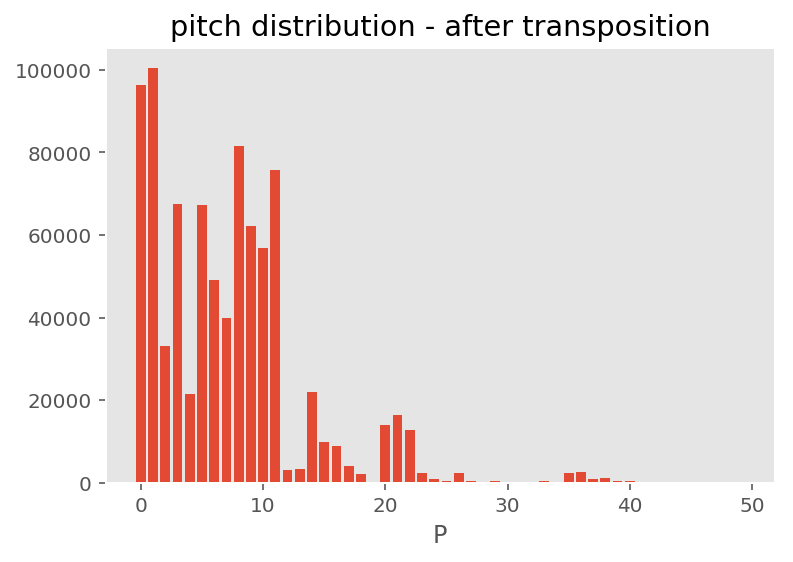

In [17]:
plot_histogram(dataset, 'P', 'pitch distribution - after transposition')

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: We reduced the space of possible durations by a factor almost 4. This impacts the training time in 2 ways: not only all the iterations of forward and backward propagation are faster, but the learning can also be more efficient, in the sense that having less possible output values helps the model focus on the important ones from the beginning.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: Once we have transposed all songs to a single tonality, the model will be insensible to the tonality of the input songs: if an identical melody is fed to the model in two different tonalities, we will get an identical output, which is what one expects from this kind of models.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: If we had kept the joint representation of duration and pitches we would have $50 \times 17 = 850$ dimensions in the input space (after rare event suppression and transposition). Instead, we have 2 input spaces of dimensions 50 and 17.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: The distribution would be a lot sparser than what he have now: indeed, we already have some durations and pitches that occur very unfrequently, so it is probable that most couples in the joint representation would not appear in the dataset.

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

sessiontune35603


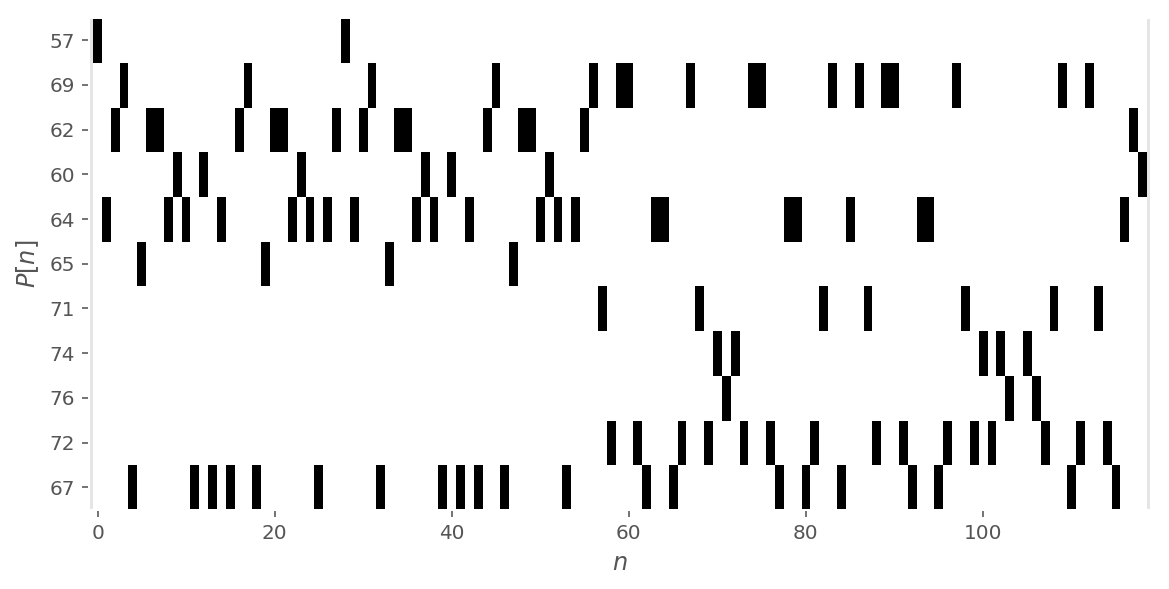

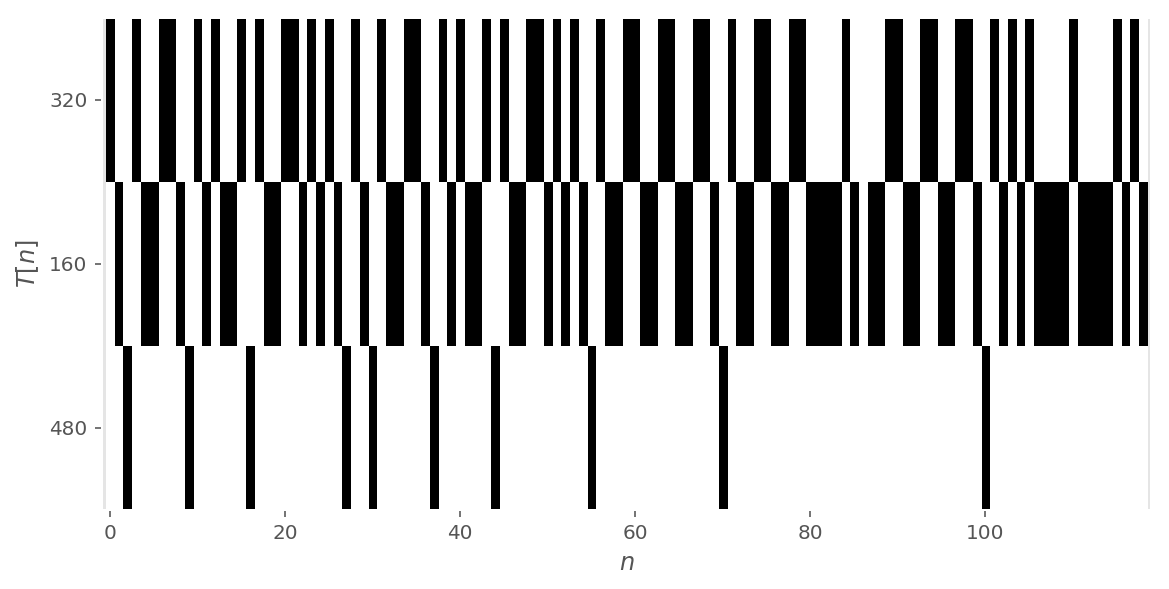

sessiontune41629


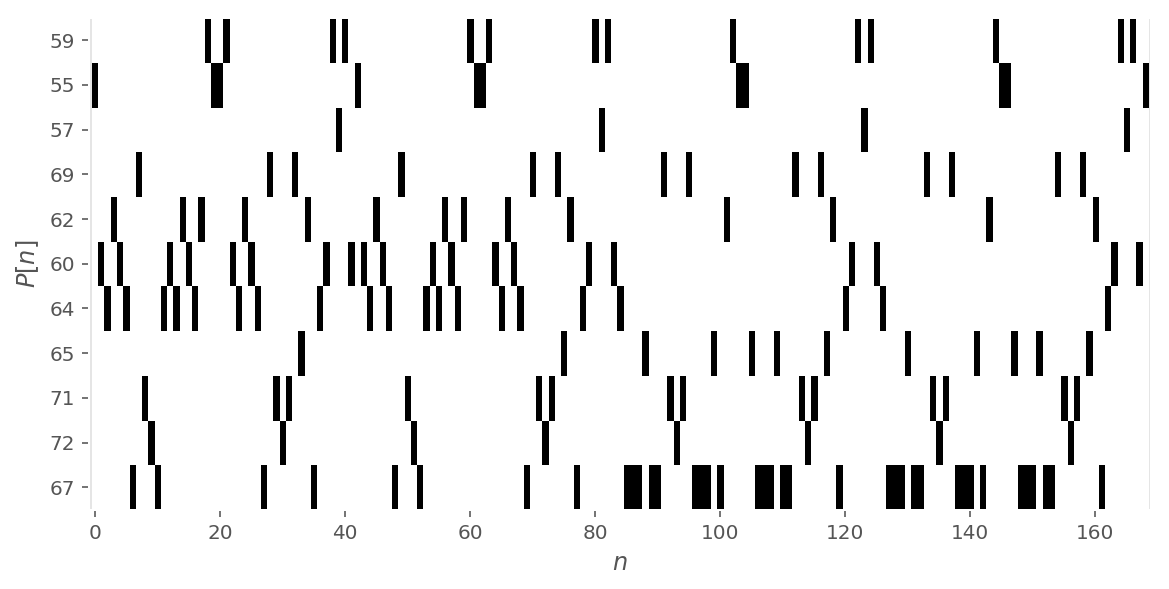

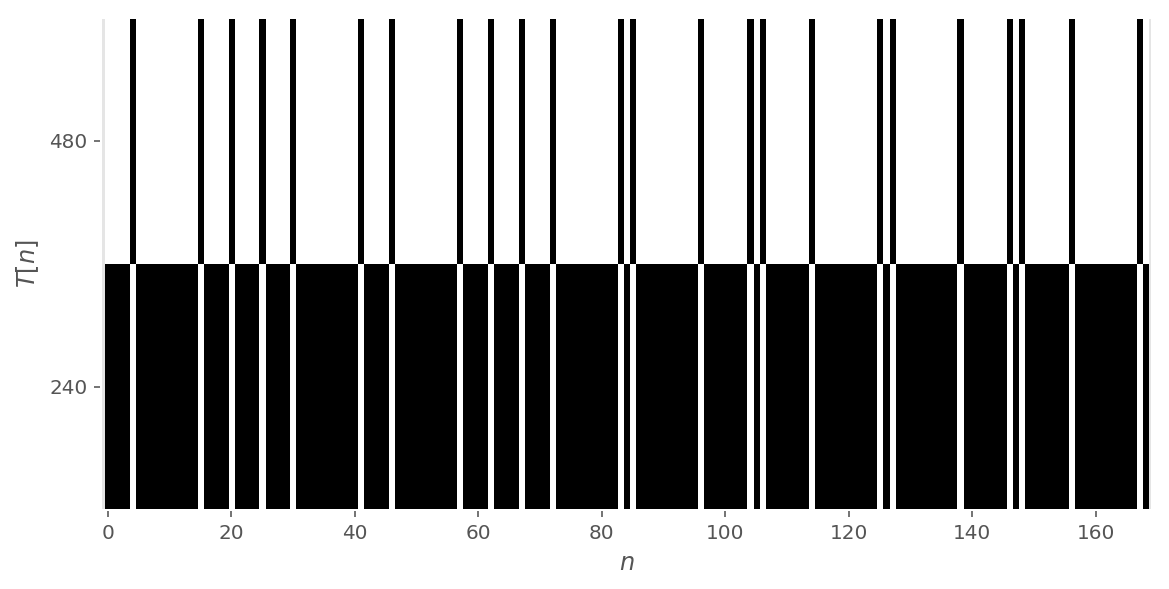

In [18]:
control_indices = np.random.choice((list(range(len(dataset)))), 2)
for i in control_indices:
    label = list(dataset.keys())[i]
    print(label)
    plotMelody(dataset[label]['P'], dataset[label]['T'], decoders)

In [19]:
# one-hot encoding
nT = len(decoders['T'])
nP = len(decoders['P'])

for label in dataset:
    dataset[label]['T'] = np_utils.to_categorical(dataset[label]['T'], num_classes=nT)
    dataset[label]['P'] = np_utils.to_categorical(dataset[label]['P'], num_classes=nP)

In [20]:
# zero-padding
lengths = [dataset[l]['T'].shape[0] for l in dataset]
maxlen = int(np.mean(lengths) + 2*np.std(lengths))

T = pad_sequences([dataset[l]['T'] for l in dataset], maxlen=maxlen, value=0, padding='post', truncating='post')
P = pad_sequences([dataset[l]['P'] for l in dataset], maxlen=maxlen, value=0, padding='post', truncating='post')

T shape:  (4465, 396, 17)
P shape:  (4465, 396, 50)


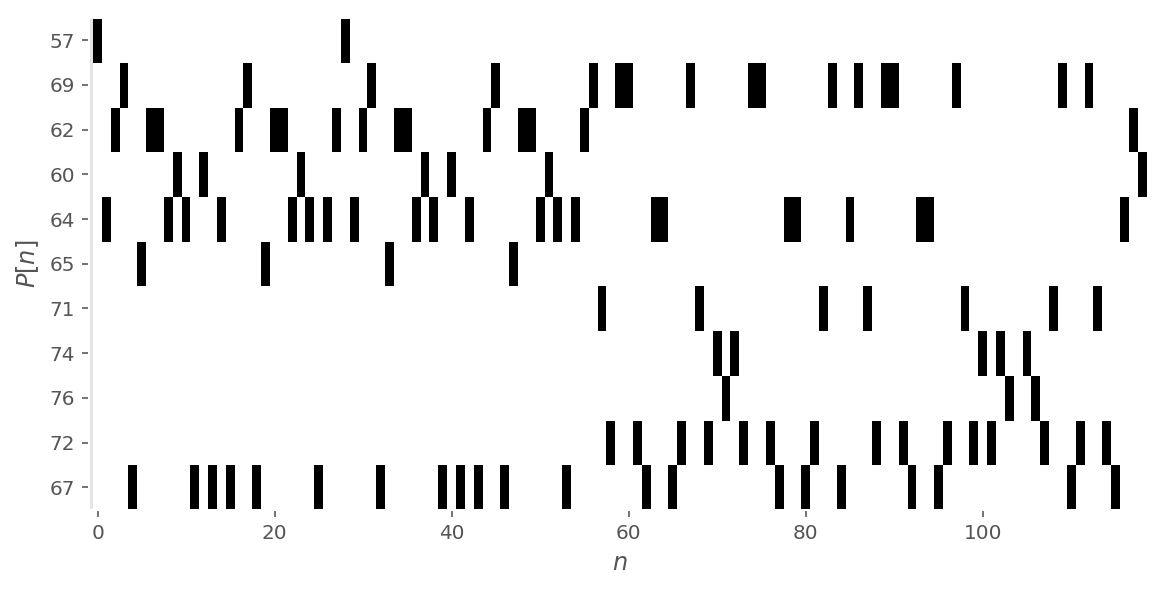

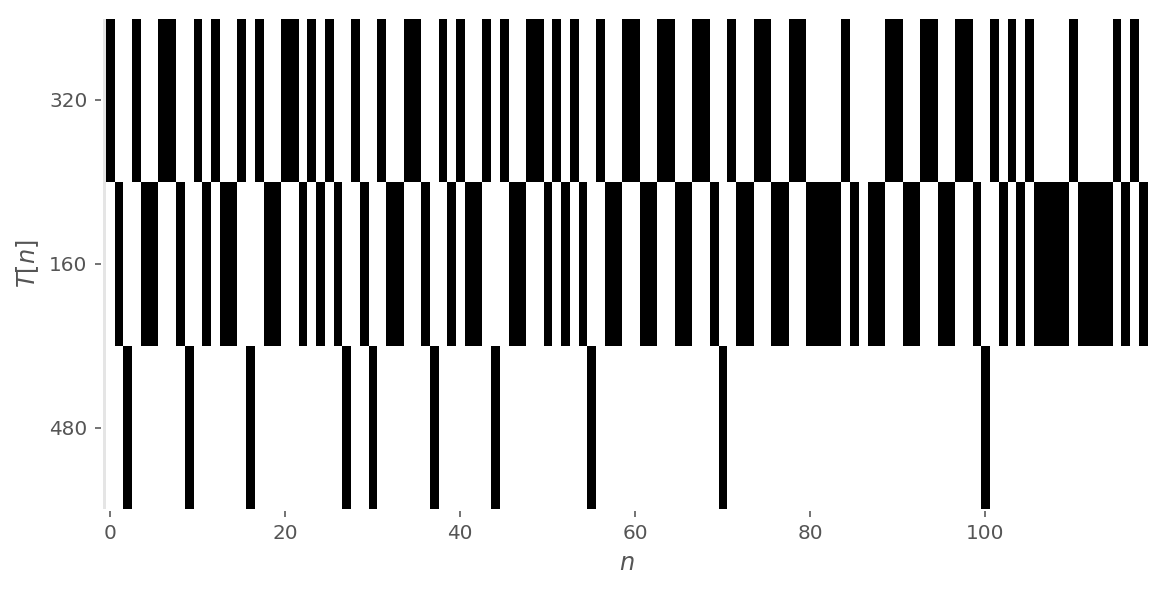

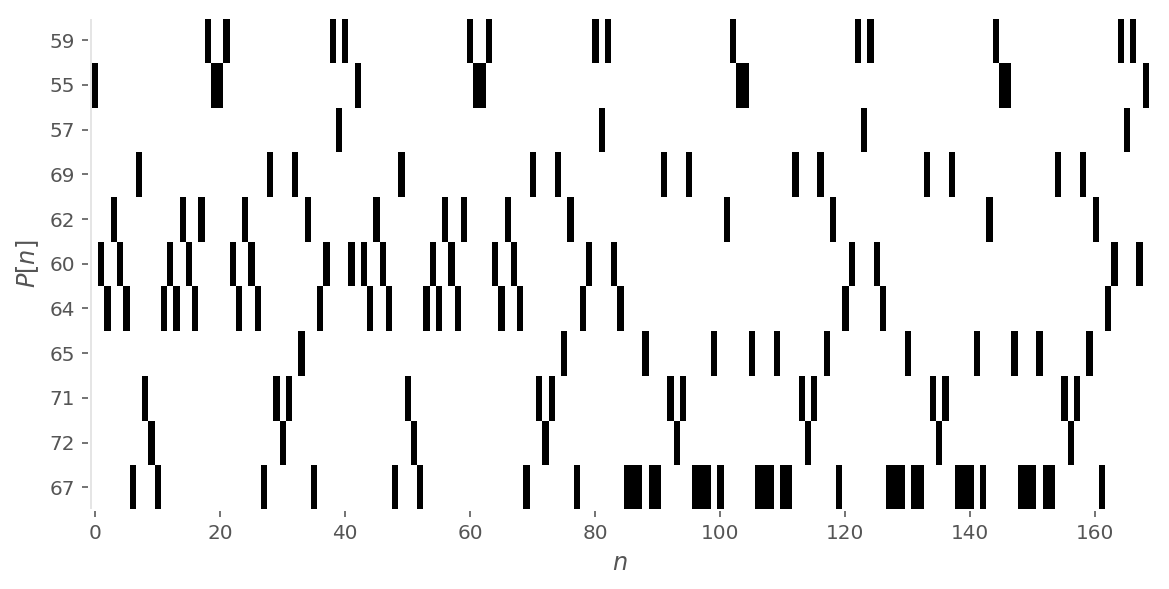

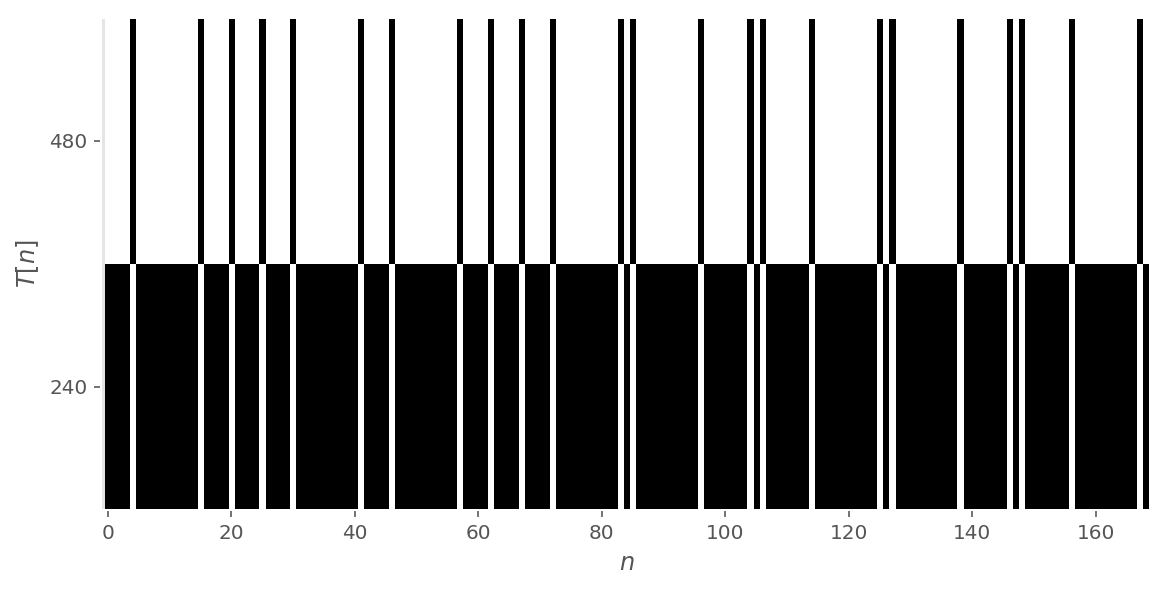

In [21]:
# control
print("T shape: ", T.shape)
print("P shape: ", P.shape)

for i in control_indices:
    plotMelody(P[i,:,:], T[i,:,:], decoders)

In [24]:
np.save('T', T)
np.save('P', P)
with open("decoders.txt", 'w') as f:
    f.write(str(decoders))

In [11]:
T = np.load('T.npy')
P = np.load('P.npy')
decoders = {'P': [67, 72, 79, 76, 77, 74, 71, 65, 64, 60, 62, 69, 70, 78, 81, 84, 83, 86, 88, 90, 57, 55, 59, 66, 68, 75, 58, 63, 82, 73, 89, 93, 95, 91, 85, 53, 52, 48, 50, 80, 61, 56, 54, 46, 51, 43, 45, 87, 47, 49], 'T': [240, 480, 120, 720, 160, 960, 1440, 320, 1200, 80, 60, 800, 360, 230, 470, 1920, 2400]}

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [9]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    
    if activation == 'GRU':
        #Your hidden layer(s) architecture with GRU
        H['2'] = GRU(Hsize, dropout=dropout, return_sequences=True, name='MergeOut')(H['1'])
    elif activation == 'LSTM':
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        H['2'] = LSTM(Hsize, dropout=dropout, return_sequences=True, name='MergeOut')(H['1'])
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        H['2'] = SimpleRNN(Hsize, dropout=dropout, return_sequences=True, name='MergeOut')(H['1'])

    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    
    return model

In [6]:
batch_length = T.shape[1]

In [56]:
#histories = dict()
#models = dict()
nepochs = 250
batch_size = 32

log = open("log.txt", 'w')

def write_perfs(histories, log):
    log.write('Final performances:\n')
    log.write('val YP loss: '+str(histories.history['val_YP_loss'][-1])+'\n')
    log.write('val YT loss: '+str(histories.history['val_YT_loss'][-1])+'\n')
    log.write('val YP acc: '+str(histories.history['val_YP_acc'][-1])+'\n')
    log.write('val YT acc: '+str(histories.history['val_YT_acc'][-1])+'\n')
    log.flush()
    
print_summaries = False
    
for dropout in [0.2]:
    if dropout == 0.2:
        print_summaries = True
    
    name = 'RNN-'+str(dropout)
    log.write("RNN, dropout={} \n".format(dropout))
    #models[name] = buildModel(decoders, batch_length=batch_length-1, dropout=dropout, activation='RNN')
    #callbYP = ModelCheckpoint(name+".bestYPacc.hdf5", monitor="val_YP_acc", save_best_only=True)
    #callbYT = ModelCheckpoint(name+".bestYTacc.hdf5", monitor="val_YT_acc", save_best_only=True)
    #histories[name] = models[name].fit([T[:,:-1,:], P[:,:-1,:]], [T[:,1:,:], P[:,1:,:]], epochs=nepochs, 
    #                                   batch_size=batch_size, validation_split=0.2, verbose=1,
    #                                  callbacks=[callbYP, callbYT])
    if print_summaries:
        models[name].summary()
    write_perfs(histories[name], log)
    
    
    name = 'GRU-'+str(dropout)
    log.write("GRU, dropout={} \n".format(dropout))
    models[name] = buildModel(decoders, batch_length=batch_length-1, dropout=dropout, activation='GRU')
    callbYP = ModelCheckpoint(name+".bestYPacc.hdf5", monitor="val_YP_acc", save_best_only=True)
    callbYT = ModelCheckpoint(name+".bestYTacc.hdf5", monitor="val_YT_acc", save_best_only=True)
    if print_summaries:
        models[name].summary()
    histories[name] = models[name].fit([T[:,:-1,:], P[:,:-1,:]], [T[:,1:,:], P[:,1:,:]], epochs=nepochs, 
                                       batch_size=batch_size, validation_split=0.2, verbose=1,
                                      callbacks=[callbYP, callbYT])
    if print_summaries:
        models[name].summary()
    write_perfs(histories[name], log)
    
    
    name = 'LSTM-'+str(dropout)
    log.write("LSTM, dropout={} \n".format(dropout))
    models[name] = buildModel(decoders, batch_length=batch_length-1, dropout=dropout, activation='LSTM')
    callbYP = ModelCheckpoint(name+".bestYPacc.hdf5", monitor="val_YP_acc", save_best_only=True)
    callbYT = ModelCheckpoint(name+".bestYTacc.hdf5", monitor="val_YT_acc", save_best_only=True)
    if print_summaries:
        models[name].summary()
    histories[name] = models[name].fit([T[:,:-1,:], P[:,:-1,:]], [T[:,1:,:], P[:,1:,:]], epochs=nepochs, 
                                       batch_size=batch_size, validation_split=0.2, verbose=1,
                                      callbacks=[callbYP, callbYT])
    if print_summaries:
        models[name].summary()
    write_perfs(histories[name], log)
    print_summaries = False

log.close()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 395, 17)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 395, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 395, 17)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 395, 50)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 16/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.4784 - YT_loss: 0.6262 - YP_loss: 1.8522 - YT_acc: 0.8137 - YP_acc: 0.3504 - val_loss: 2.4083 - val_YT_loss: 0.6265 - val_YP_loss: 1.7818 - val_YT_acc: 0.8080 - val_YP_acc: 0.3691
Epoch 17/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.4652 - YT_loss: 0.6227 - YP_loss: 1.8425 - YT_acc: 0.8140 - YP_acc: 0.3533 - val_loss: 2.4033 - val_YT_loss: 0.6237 - val_YP_loss: 1.7796 - val_YT_acc: 0.8085 - val_YP_acc: 0.3695
Epoch 18/250
3572/3572 [==============================] - 41s 12ms/step - loss: 2.4645 - YT_loss: 0.6270 - YP_loss: 1.8375 - YT_acc: 0.8126 - YP_acc: 0.3561 - val_loss: 2.4101 - val_YT_loss: 0.6333 - val_YP_loss: 1.7768 - val_YT_acc: 0.8068 - val_YP_acc: 0.3725
Epoch 19/250
3572/3572 [==============================] - 41s 12ms/step - loss: 2.4492 - YT_loss: 0.6187 - YP_loss: 1.8305 - YT_acc: 0.8150 - YP_acc: 0.3588 - val_loss: 2.3765 - val_YT_loss: 0.6125 - val_YP_loss: 1

3572/3572 [==============================] - 42s 12ms/step - loss: 2.1013 - YT_loss: 0.4991 - YP_loss: 1.6021 - YT_acc: 0.8355 - YP_acc: 0.4411 - val_loss: 2.0904 - val_YT_loss: 0.5122 - val_YP_loss: 1.5782 - val_YT_acc: 0.8281 - val_YP_acc: 0.4467
Epoch 79/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.0921 - YT_loss: 0.4947 - YP_loss: 1.5974 - YT_acc: 0.8363 - YP_acc: 0.4435 - val_loss: 2.0892 - val_YT_loss: 0.5116 - val_YP_loss: 1.5776 - val_YT_acc: 0.8281 - val_YP_acc: 0.4474
Epoch 80/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.0978 - YT_loss: 0.4998 - YP_loss: 1.5980 - YT_acc: 0.8354 - YP_acc: 0.4429 - val_loss: 2.0869 - val_YT_loss: 0.5115 - val_YP_loss: 1.5754 - val_YT_acc: 0.8281 - val_YP_acc: 0.4487
Epoch 81/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.0893 - YT_loss: 0.4955 - YP_loss: 1.5938 - YT_acc: 0.8359 - YP_acc: 0.4437 - val_loss: 2.0831 - val_YT_loss: 0.5116 - val_YP_loss: 1.5715 - val_Y

3572/3572 [==============================] - 42s 12ms/step - loss: 2.0128 - YT_loss: 0.4810 - YP_loss: 1.5318 - YT_acc: 0.8392 - YP_acc: 0.4652 - val_loss: 2.0489 - val_YT_loss: 0.5079 - val_YP_loss: 1.5409 - val_YT_acc: 0.8280 - val_YP_acc: 0.4642
Epoch 141/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.0023 - YT_loss: 0.4765 - YP_loss: 1.5258 - YT_acc: 0.8400 - YP_acc: 0.4683 - val_loss: 2.0397 - val_YT_loss: 0.5037 - val_YP_loss: 1.5360 - val_YT_acc: 0.8285 - val_YP_acc: 0.4649
Epoch 142/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.0008 - YT_loss: 0.4765 - YP_loss: 1.5243 - YT_acc: 0.8398 - YP_acc: 0.4691 - val_loss: 2.0460 - val_YT_loss: 0.5059 - val_YP_loss: 1.5401 - val_YT_acc: 0.8288 - val_YP_acc: 0.4639
Epoch 143/250
3572/3572 [==============================] - 42s 12ms/step - loss: 2.0013 - YT_loss: 0.4769 - YP_loss: 1.5243 - YT_acc: 0.8394 - YP_acc: 0.4685 - val_loss: 2.0421 - val_YT_loss: 0.5033 - val_YP_loss: 1.5387 - va

3572/3572 [==============================] - 42s 12ms/step - loss: 1.9506 - YT_loss: 0.4643 - YP_loss: 1.4864 - YT_acc: 0.8423 - YP_acc: 0.4823 - val_loss: 2.0275 - val_YT_loss: 0.4999 - val_YP_loss: 1.5276 - val_YT_acc: 0.8288 - val_YP_acc: 0.4692
Epoch 203/250
3572/3572 [==============================] - 41s 12ms/step - loss: 1.9571 - YT_loss: 0.4676 - YP_loss: 1.4895 - YT_acc: 0.8409 - YP_acc: 0.4814 - val_loss: 2.0281 - val_YT_loss: 0.4999 - val_YP_loss: 1.5283 - val_YT_acc: 0.8279 - val_YP_acc: 0.4695
Epoch 204/250
3572/3572 [==============================] - 41s 12ms/step - loss: 1.9643 - YT_loss: 0.4709 - YP_loss: 1.4934 - YT_acc: 0.8410 - YP_acc: 0.4795 - val_loss: 2.0356 - val_YT_loss: 0.5054 - val_YP_loss: 1.5302 - val_YT_acc: 0.8277 - val_YP_acc: 0.4684
Epoch 205/250
3572/3572 [==============================] - 41s 12ms/step - loss: 2.0228 - YT_loss: 0.4861 - YP_loss: 1.5367 - YT_acc: 0.8401 - YP_acc: 0.4629 - val_loss: 2.0341 - val_YT_loss: 0.5019 - val_YP_loss: 1.5323 - va

Train on 3572 samples, validate on 893 samples
Epoch 1/250
3572/3572 [==============================] - 45s 13ms/step - loss: 4.0888 - YT_loss: 1.2051 - YP_loss: 2.8836 - YT_acc: 0.7064 - YP_acc: 0.1377 - val_loss: 3.5843 - val_YT_loss: 1.0105 - val_YP_loss: 2.5738 - val_YT_acc: 0.7362 - val_YP_acc: 0.1757
Epoch 2/250
3572/3572 [==============================] - 44s 12ms/step - loss: 3.3681 - YT_loss: 0.9017 - YP_loss: 2.4665 - YT_acc: 0.7512 - YP_acc: 0.2049 - val_loss: 3.1731 - val_YT_loss: 0.8460 - val_YP_loss: 2.3271 - val_YT_acc: 0.7520 - val_YP_acc: 0.2304
Epoch 3/250
3572/3572 [==============================] - 44s 12ms/step - loss: 3.1104 - YT_loss: 0.8225 - YP_loss: 2.2879 - YT_acc: 0.7624 - YP_acc: 0.2433 - val_loss: 2.9797 - val_YT_loss: 0.8042 - val_YP_loss: 2.1755 - val_YT_acc: 0.7555 - val_YP_acc: 0.2652
Epoch 4/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.9552 - YT_loss: 0.7853 - YP_loss: 2.1699 - YT_acc: 0.7694 - YP_acc: 0.2679 - val_loss: 2.

3572/3572 [==============================] - 44s 12ms/step - loss: 2.2096 - YT_loss: 0.5406 - YP_loss: 1.6690 - YT_acc: 0.8303 - YP_acc: 0.4143 - val_loss: 2.1875 - val_YT_loss: 0.5540 - val_YP_loss: 1.6334 - val_YT_acc: 0.8230 - val_YP_acc: 0.4240
Epoch 64/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.2066 - YT_loss: 0.5389 - YP_loss: 1.6676 - YT_acc: 0.8304 - YP_acc: 0.4146 - val_loss: 2.1804 - val_YT_loss: 0.5490 - val_YP_loss: 1.6314 - val_YT_acc: 0.8235 - val_YP_acc: 0.4248
Epoch 65/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.2028 - YT_loss: 0.5363 - YP_loss: 1.6665 - YT_acc: 0.8308 - YP_acc: 0.4155 - val_loss: 2.1805 - val_YT_loss: 0.5471 - val_YP_loss: 1.6334 - val_YT_acc: 0.8239 - val_YP_acc: 0.4242
Epoch 66/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.1985 - YT_loss: 0.5346 - YP_loss: 1.6639 - YT_acc: 0.8311 - YP_acc: 0.4155 - val_loss: 2.1753 - val_YT_loss: 0.5443 - val_YP_loss: 1.6310 - val_Y

3572/3572 [==============================] - 44s 12ms/step - loss: 2.0178 - YT_loss: 0.4736 - YP_loss: 1.5442 - YT_acc: 0.8398 - YP_acc: 0.4593 - val_loss: 2.0749 - val_YT_loss: 0.5166 - val_YP_loss: 1.5584 - val_YT_acc: 0.8287 - val_YP_acc: 0.4532
Epoch 126/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.0186 - YT_loss: 0.4745 - YP_loss: 1.5441 - YT_acc: 0.8400 - YP_acc: 0.4602 - val_loss: 2.0464 - val_YT_loss: 0.5011 - val_YP_loss: 1.5453 - val_YT_acc: 0.8301 - val_YP_acc: 0.4590
Epoch 127/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.0183 - YT_loss: 0.4751 - YP_loss: 1.5433 - YT_acc: 0.8398 - YP_acc: 0.4604 - val_loss: 2.0434 - val_YT_loss: 0.4996 - val_YP_loss: 1.5438 - val_YT_acc: 0.8304 - val_YP_acc: 0.4603
Epoch 128/250
3572/3572 [==============================] - 44s 12ms/step - loss: 2.0126 - YT_loss: 0.4720 - YP_loss: 1.5406 - YT_acc: 0.8401 - YP_acc: 0.4611 - val_loss: 2.0433 - val_YT_loss: 0.4991 - val_YP_loss: 1.5441 - va

3572/3572 [==============================] - 44s 12ms/step - loss: 1.9305 - YT_loss: 0.4555 - YP_loss: 1.4750 - YT_acc: 0.8439 - YP_acc: 0.4860 - val_loss: 2.0050 - val_YT_loss: 0.4942 - val_YP_loss: 1.5108 - val_YT_acc: 0.8313 - val_YP_acc: 0.4734
Epoch 188/250
3572/3572 [==============================] - 44s 12ms/step - loss: 1.9344 - YT_loss: 0.4572 - YP_loss: 1.4772 - YT_acc: 0.8437 - YP_acc: 0.4846 - val_loss: 2.0066 - val_YT_loss: 0.4938 - val_YP_loss: 1.5128 - val_YT_acc: 0.8314 - val_YP_acc: 0.4731
Epoch 189/250
3572/3572 [==============================] - 44s 12ms/step - loss: 1.9332 - YT_loss: 0.4577 - YP_loss: 1.4755 - YT_acc: 0.8434 - YP_acc: 0.4853 - val_loss: 2.0035 - val_YT_loss: 0.4922 - val_YP_loss: 1.5113 - val_YT_acc: 0.8314 - val_YP_acc: 0.4734
Epoch 190/250
3572/3572 [==============================] - 44s 12ms/step - loss: 1.9286 - YT_loss: 0.4563 - YP_loss: 1.4724 - YT_acc: 0.8436 - YP_acc: 0.4856 - val_loss: 2.0057 - val_YT_loss: 0.4923 - val_YP_loss: 1.5133 - va

3572/3572 [==============================] - 44s 12ms/step - loss: 1.8873 - YT_loss: 0.4489 - YP_loss: 1.4384 - YT_acc: 0.8450 - YP_acc: 0.4984 - val_loss: 1.9922 - val_YT_loss: 0.4919 - val_YP_loss: 1.5004 - val_YT_acc: 0.8310 - val_YP_acc: 0.4796
Epoch 250/250
3572/3572 [==============================] - 44s 12ms/step - loss: 1.8868 - YT_loss: 0.4488 - YP_loss: 1.4380 - YT_acc: 0.8450 - YP_acc: 0.4991 - val_loss: 1.9905 - val_YT_loss: 0.4903 - val_YP_loss: 1.5002 - val_YT_acc: 0.8315 - val_YP_acc: 0.4791
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 395, 17)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 395, 50)      0                                      

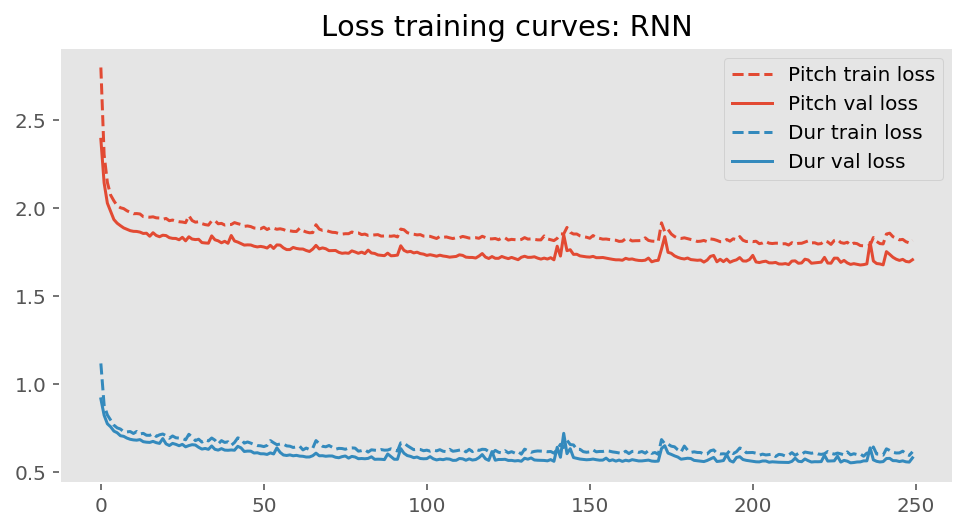

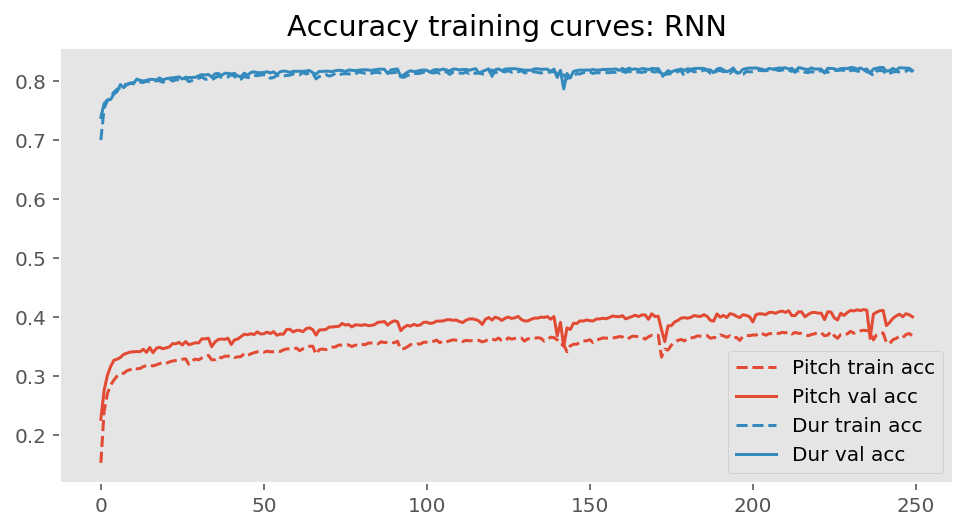

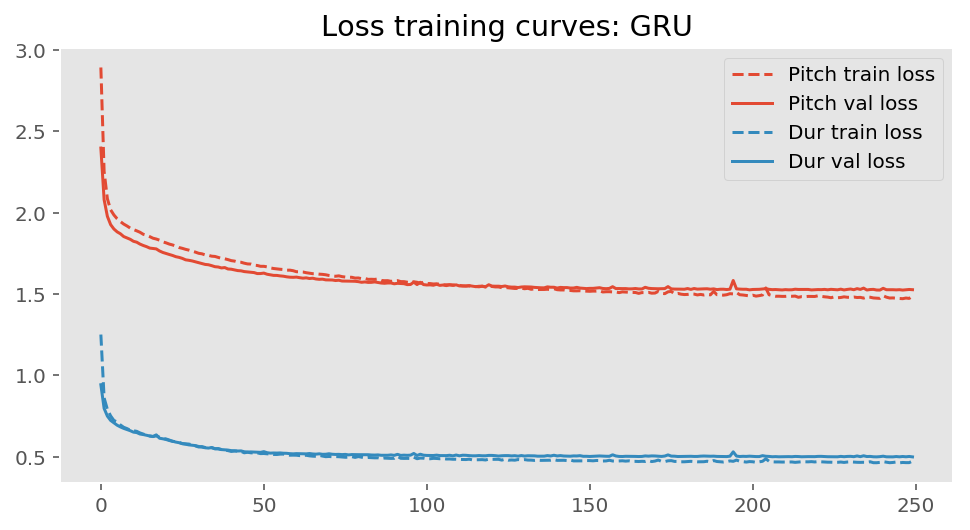

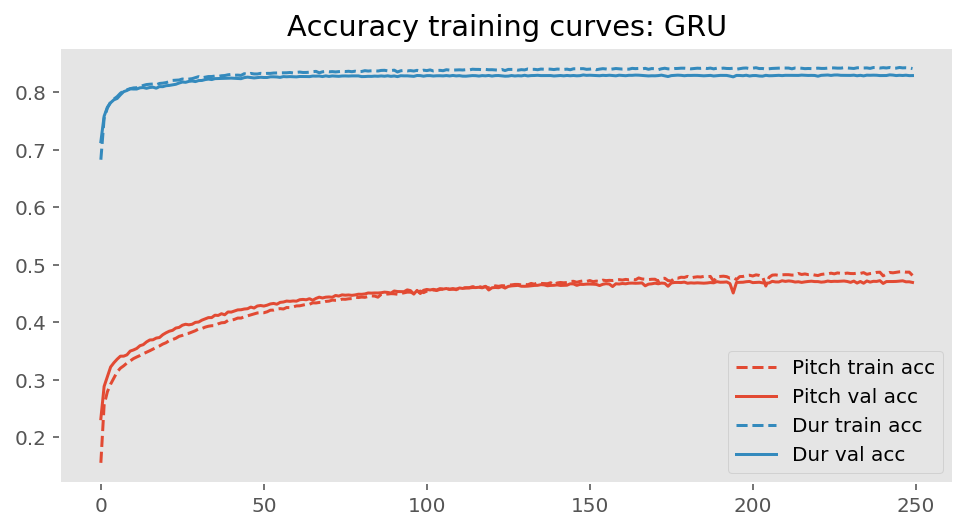

In [57]:
plotLearningCurves(histories['RNN-0.2'], model='RNN')
plotLearningCurves(histories['GRU-0.2'], model='GRU')

In [39]:
def earlyStopping(history):
    hist = history.history
    idx = np.argmin(np.array(hist["val_YP_loss"]) + np.array(hist["val_YT_loss"]))
    return {"val_YP_loss": hist["val_YP_loss"][idx], 
           "val_YT_loss": hist["val_YT_loss"][idx],
           "val_YP_acc": hist["val_YP_acc"][idx],
           "val_YT_acc": hist["val_YT_acc"][idx]}

Here are the accuracies obtained:

In [38]:
results = dict()
for key in histories:
    results[key] = earlyStopping(histories[key])
    

print("{:20} |{:8.1f}| {:8.1f}| {:8.1f}|".format("Dropout rate:", 0.1, 0.2, 0.3))
print("---------------------------------------------------")
key = 'RNN-'
print("{:20} |{:8.3f}| {:8.3f}| {:8.3f}|".format("RNN: YP acc:", histories[key+str(0.1)]["val_YP_acc"], histories[key+str(0.2)]["val_YP_acc"], histories[key+str(0.3)]["val_YP_acc"]))
print("{:20} |{:8.3f}| {:8.3f}| {:8.3f}|".format("     YT acc:", histories[key+str(0.1)]["val_YT_acc"], histories[key+str(0.2)]["val_YT_acc"], histories[key+str(0.3)]["val_YT_acc"]))
print("---------------------------------------------------")
key = 'GRU-'
print("{:20} |{:8.3f}| {:8.3f}| {:8.3f}|".format("GRU: YP acc:", histories[key+str(0.1)]["val_YP_acc"], histories[key+str(0.2)]["val_YP_acc"], histories[key+str(0.3)]["val_YP_acc"]))
print("{:20} |{:8.3f}| {:8.3f}| {:8.3f}|".format("     YT acc:", histories[key+str(0.1)]["val_YT_acc"], histories[key+str(0.2)]["val_YT_acc"], histories[key+str(0.3)]["val_YT_acc"])
print("---------------------------------------------------")
key = 'LSTM-'
print("{:20} |{:8.3f}| {:8.3f}| {:8.3f}|".format("LSTM: YP acc:", histories[key+str(0.1)]["val_YP_acc"], histories[key+str(0.2)]["val_YP_acc"], histories[key+str(0.3)]["val_YP_acc"]))
print("{:20} |{:8.3f}| {:8.3f}| {:8.3f}|".format("      YT acc:", histories[key+str(0.1)]["val_YT_acc"], histories[key+str(0.2)]["val_YT_acc"], histories[key+str(0.3)]["val_YT_acc"])

Dropout rate:        |     0.1|      0.2|      0.3|
---------------------------------------------------
RNN: YP acc:         |   0.425|    0.416|    0.401|
     YT acc:         |   0.820|    0.822|    0.818|
---------------------------------------------------
GRU: YP acc:         |   0.472|    0.472|    0.464|
     YT acc:         |   0.827|    0.830|    0.831|
---------------------------------------------------
LSTM: YP acc:        |   0.478|    0.477|    0.471|
      YT acc:        |   0.830|    0.830|    0.830|


**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: The main pattern one can observe is that on pitch sequences GRU and LSTM model are significantly better than RNN. The differences on duration sequences are much smaller. As for the difference between GRU and LSTM, and the effect of dropout, differences are too small to conclude anything.

The best models appear to be LSTM with 0.1 dropout, and GRU with 0.2 dropout if we ignore LSTMs.

Here are some comparisons of learning curves:

In [58]:
def compareLearningCurves(History1, History2, model1="", model2=""):
    
    log1 = History1.history
    log2 = History2.history
    
    plt.figure(figsize=(8,4))
    plt.title("Pitch loss training curves: "+model1+' vs '+model2)
    plt.plot(log1['YP_loss'], '--', c=c[0], label=model1+' train')
    plt.plot(log1['val_YP_loss'], c=c[0], label=model1+' val')
    
    plt.plot(log2['YP_loss'], '--', c=c[1], label=model2+' train')
    plt.plot(log2['val_YP_loss'], c=c[1], label=model2+' val')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.title("Duration loss training curves: "+model1+' vs '+model2)
    plt.plot(log1['YT_loss'], '--', c=c[0], label=model1+' train')
    plt.plot(log1['val_YT_loss'], c=c[0], label=model1+' val')
    
    plt.plot(log2['YT_loss'], '--', c=c[1], label=model2+' train')
    plt.plot(log2['val_YT_loss'], c=c[1], label=model2+' val')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.title("Pitch accuracy training curves: "+model1+' vs '+model2)
    plt.plot(log1['YP_acc'], '--', c=c[0], label=model1+' train')
    plt.plot(log1['val_YP_acc'], c=c[0], label=model1+' val')
    
    plt.plot(log2['YP_acc'], '--', c=c[1], label=model2+' train')
    plt.plot(log2['val_YP_acc'], c=c[1], label=model2+' val')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.title("Duration accuracy training curves: "+model1+' vs '+model2)
    plt.plot(log1['YT_acc'], '--', c=c[0], label=model1+' train')
    plt.plot(log1['val_YT_acc'], c=c[0], label=model1+' val')
    
    plt.plot(log2['YT_acc'], '--', c=c[1], label=model2+' train')
    plt.plot(log2['val_YT_acc'], c=c[1], label=model2+' val')
    plt.legend(loc='best')

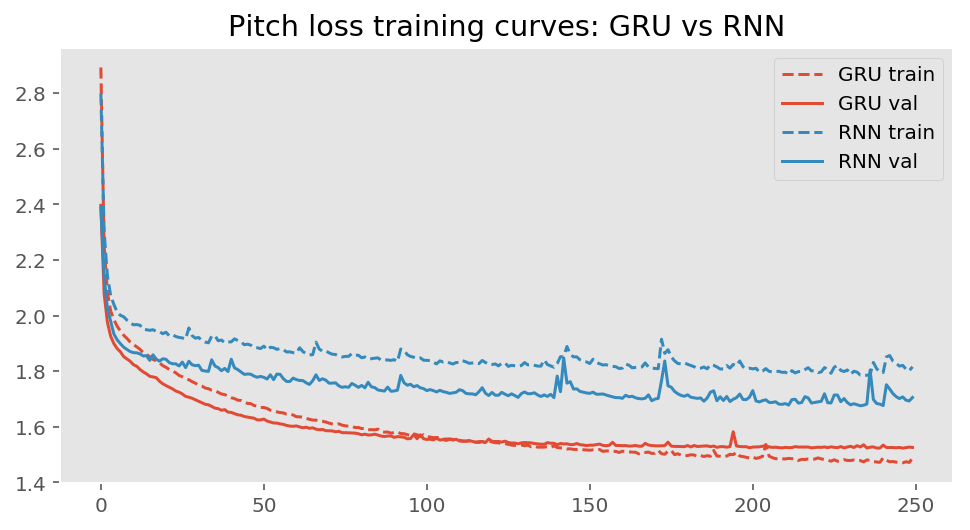

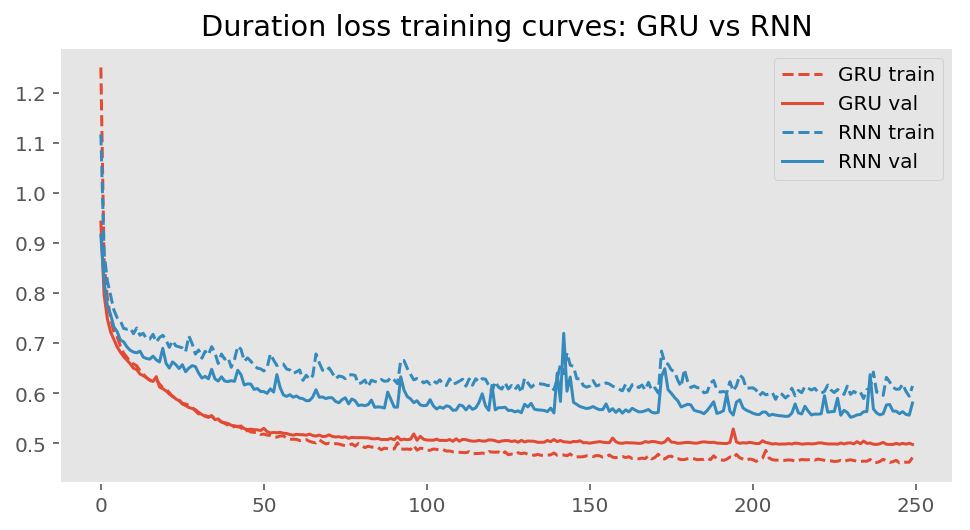

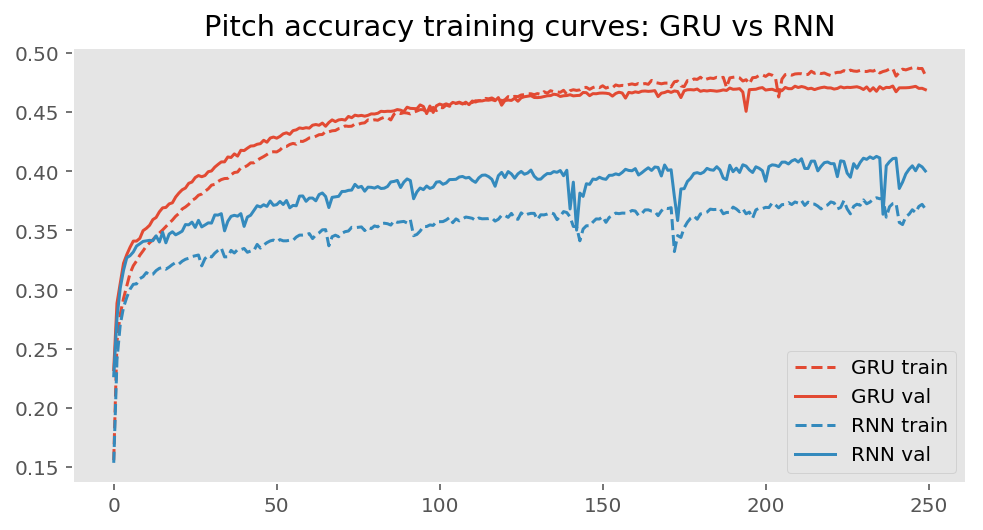

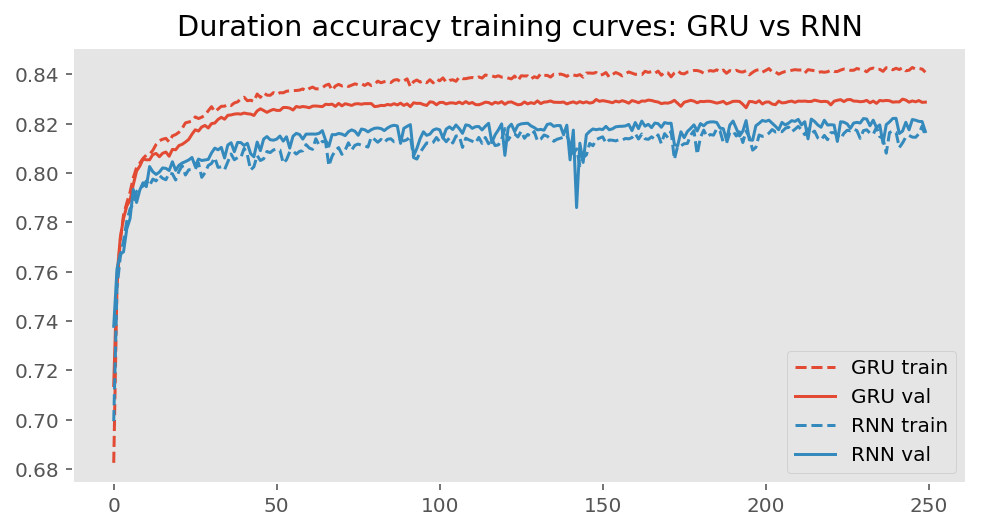

In [59]:
compareLearningCurves(histories['GRU-0.2'], histories['RNN-0.2'], 'GRU', 'RNN')



**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: Two facts are clearly apparent from the comparison of the learning curves: first the GRU model seems to be able to learn better from the data since the loss curves are constantly below those of the RNN model, and the accuracy curves above. The second fact is that learning seems to be more stable in the GRU model: indeed, the RNN's curves seems quite noisy, with sometimes important decreases in performance during a few steps. Tha GRU can probably avoid these instabilities thanks to its gating mechanism.
(NB: one should note when comparing the above curves that the comparison is somehow unfair, given that the GRU has more parameters than the RNN, as seen in the model summaries above)


In [60]:
#selected_model = models['GRU-0.2']
selected_model = buildModel(decoders, T.shape[1]-1, dropout=0.2, activation='GRU')
selected_model.load_weights('GRU-0.2.bestYPacc.hdf5')

## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

In [61]:
# select 4 random melodies
rnd_melodies = np.random.choice(np.arange(P.shape[0]), 4)

In [62]:
# new model outputting hidden units activations:
def build_modified_model(original_model):
    recurrent_layer = original_model.layers[5]
    return Model(inputs = original_model.inputs, outputs = recurrent_layer.output)

modified_model = build_modified_model(selected_model)

Let us start by plotting predicted melodies and hidden state dynamics for the GRU model

Song # 2347
1/1 [==============================] - 0s 491ms/step
YT accuracy on this song: 0.7929
YP accuracy on this song: 0.4545


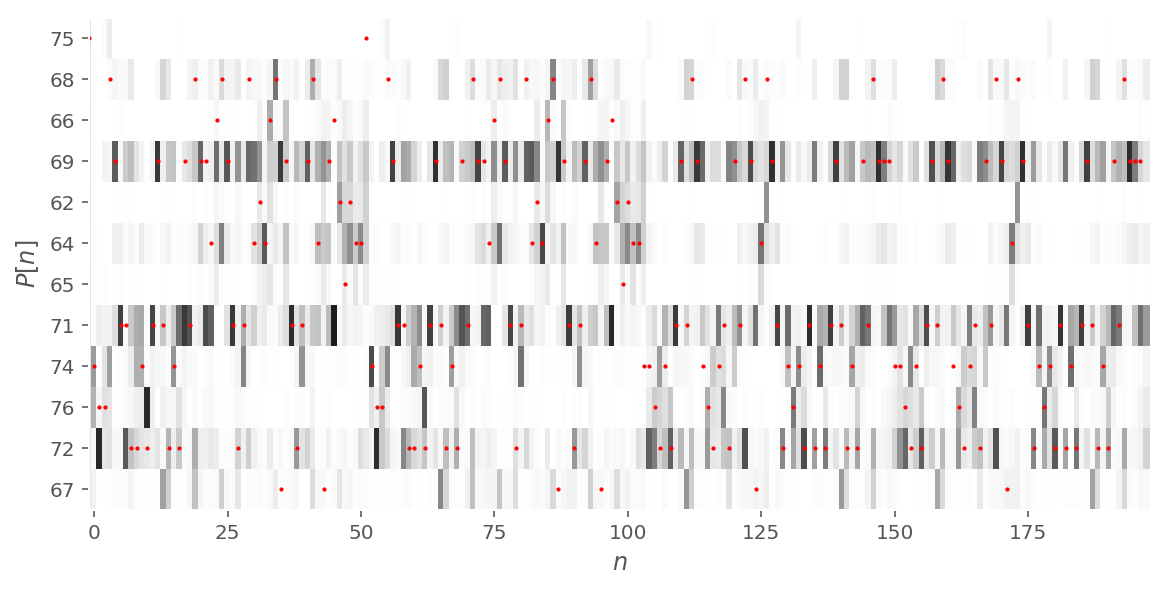

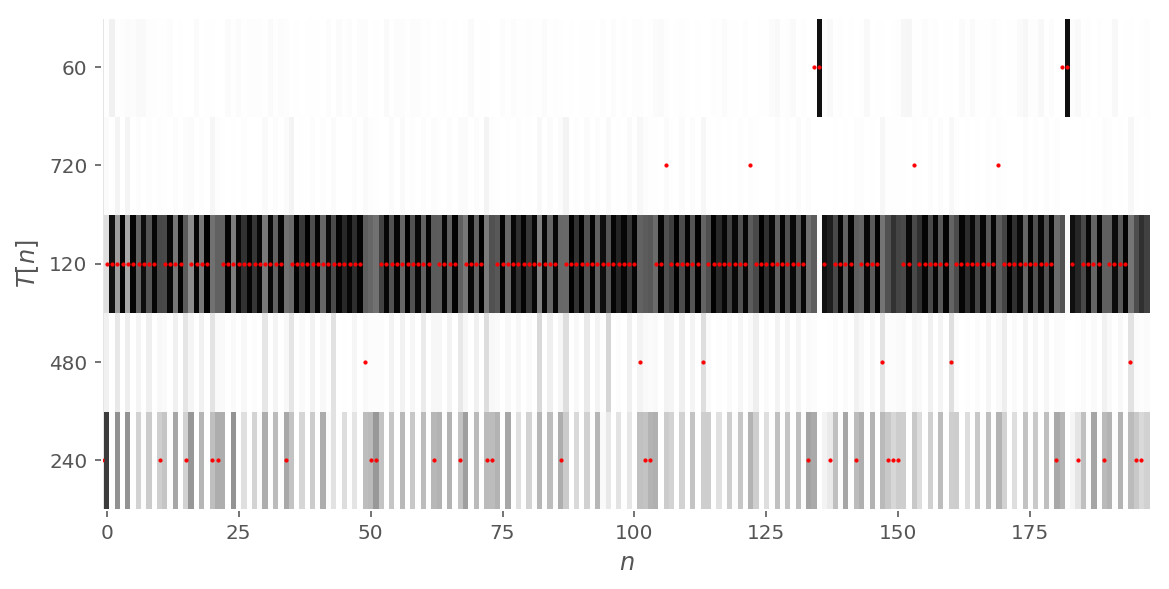

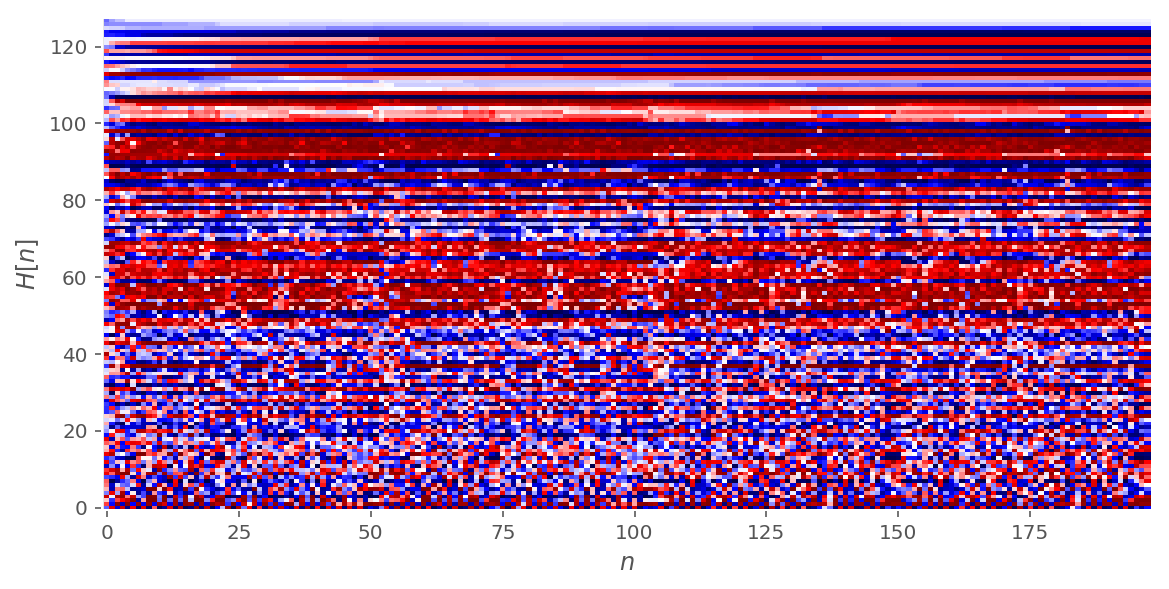

Song # 1516
1/1 [==============================] - 0s 33ms/step
YT accuracy on this song: 0.9451
YP accuracy on this song: 0.3407


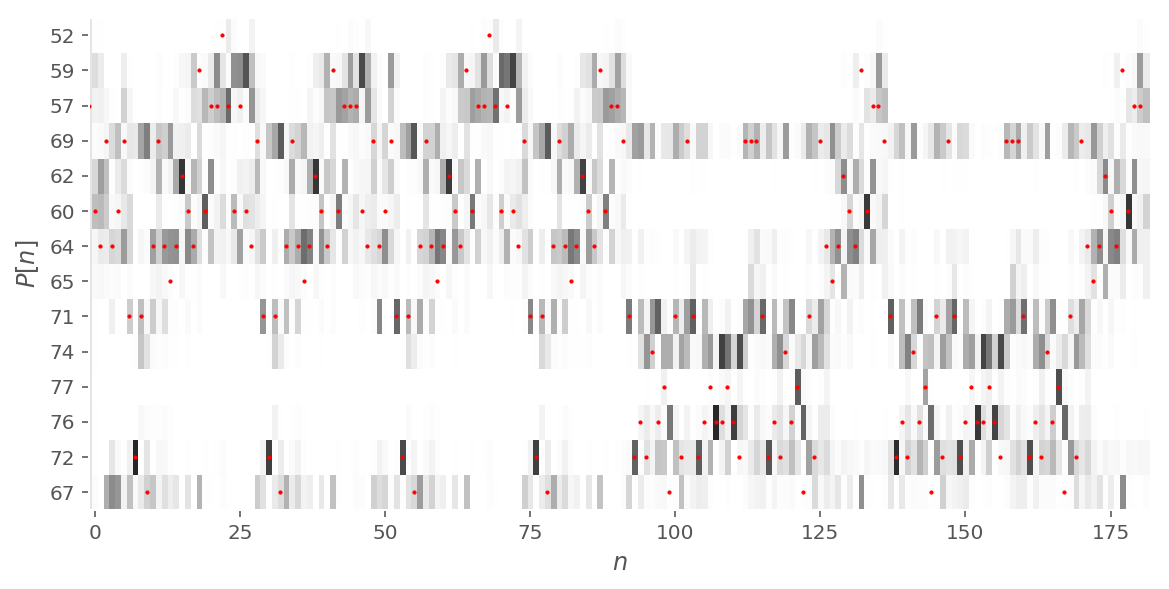

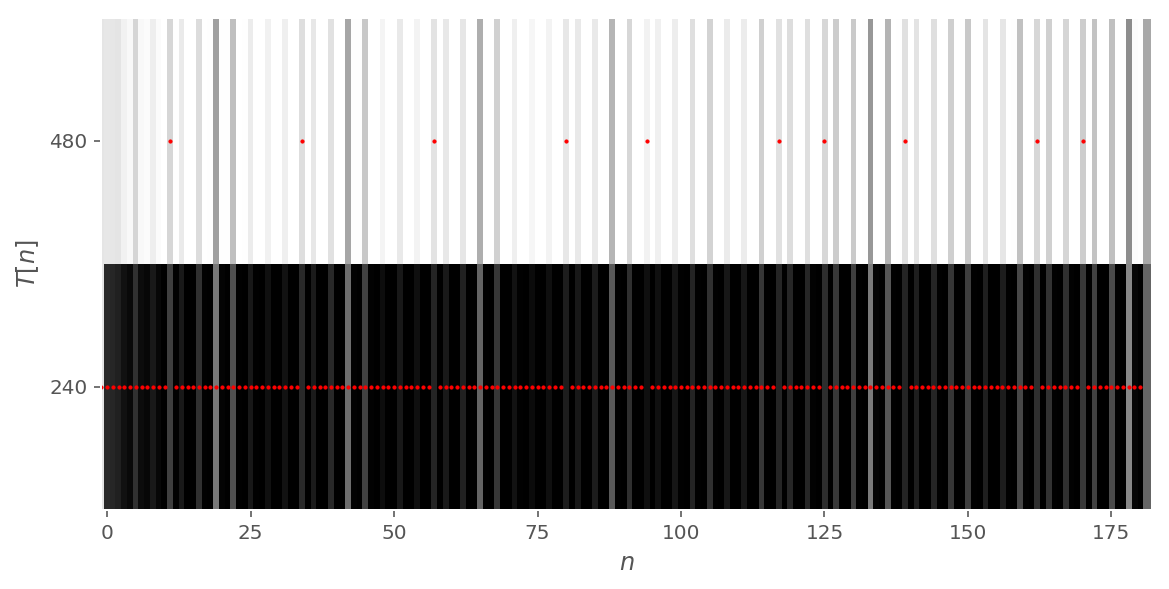

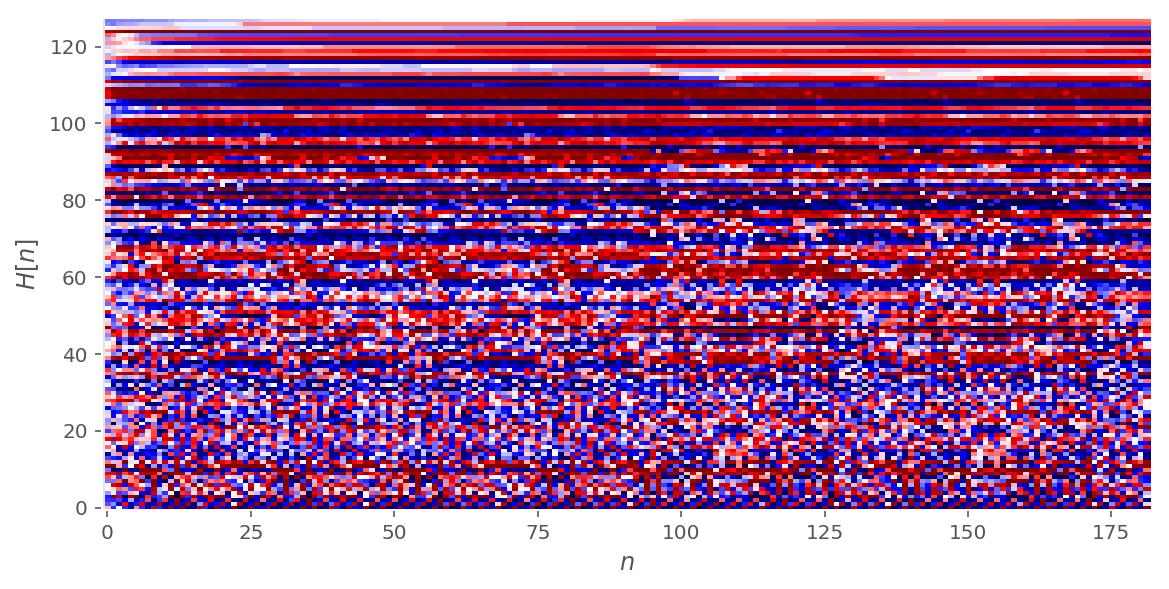

Song # 3713
1/1 [==============================] - 0s 33ms/step
YT accuracy on this song: 0.5238
YP accuracy on this song: 0.3810


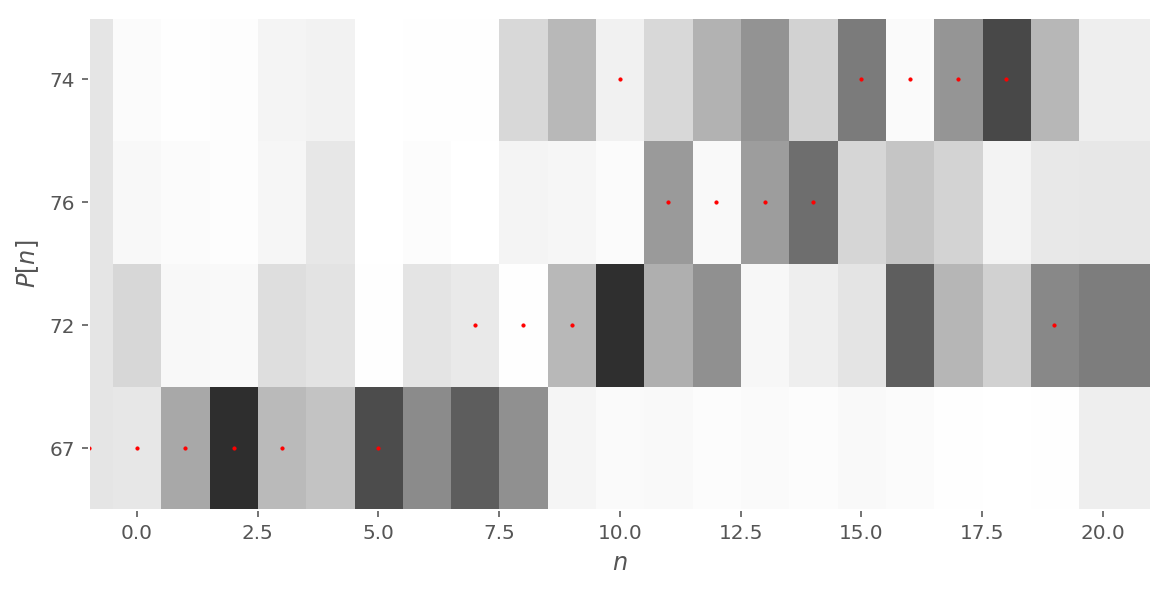

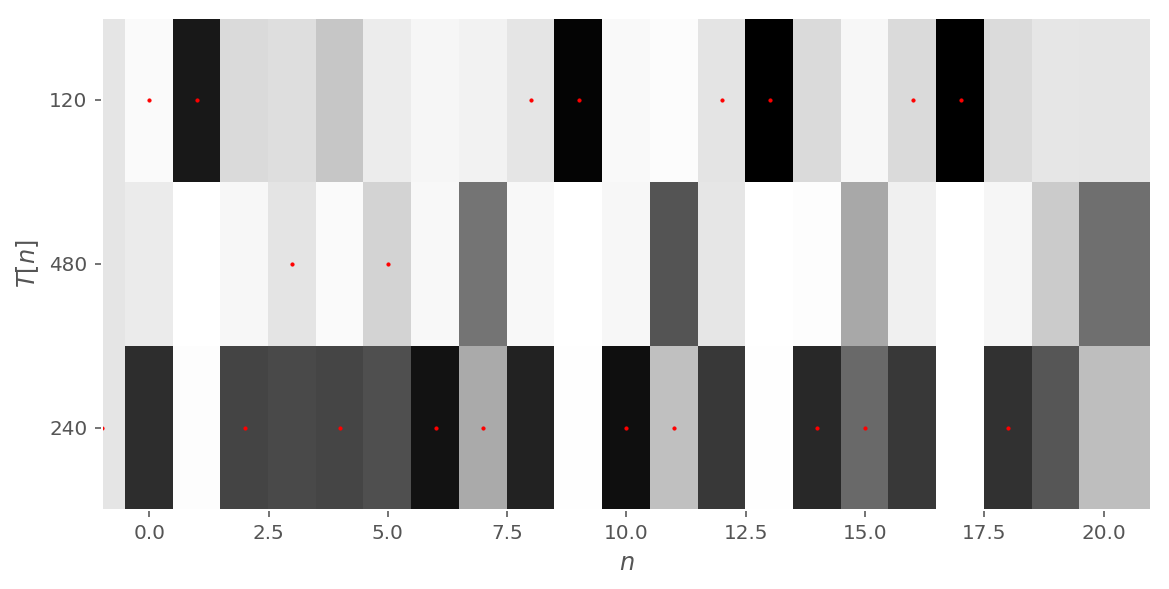

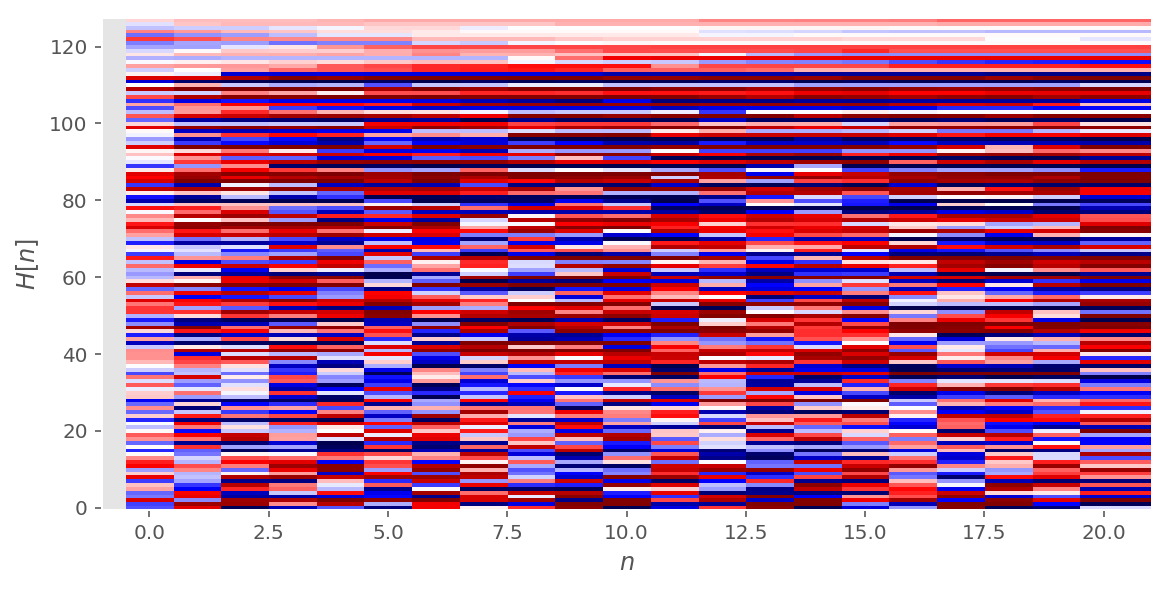

Song # 1045
1/1 [==============================] - 0s 32ms/step
YT accuracy on this song: 0.9410
YP accuracy on this song: 0.5055


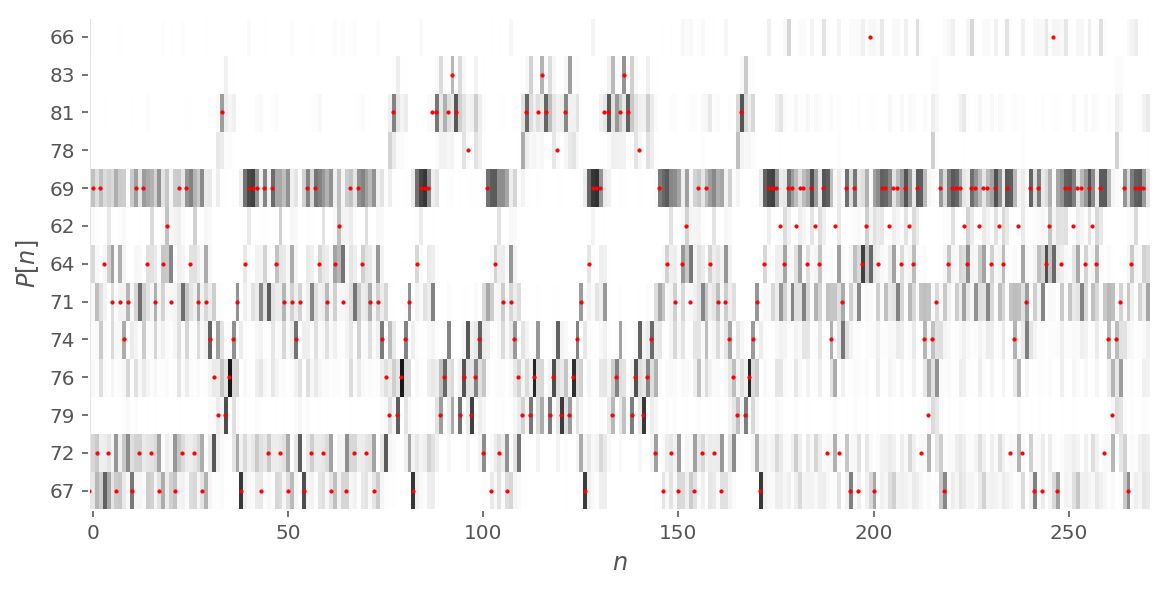

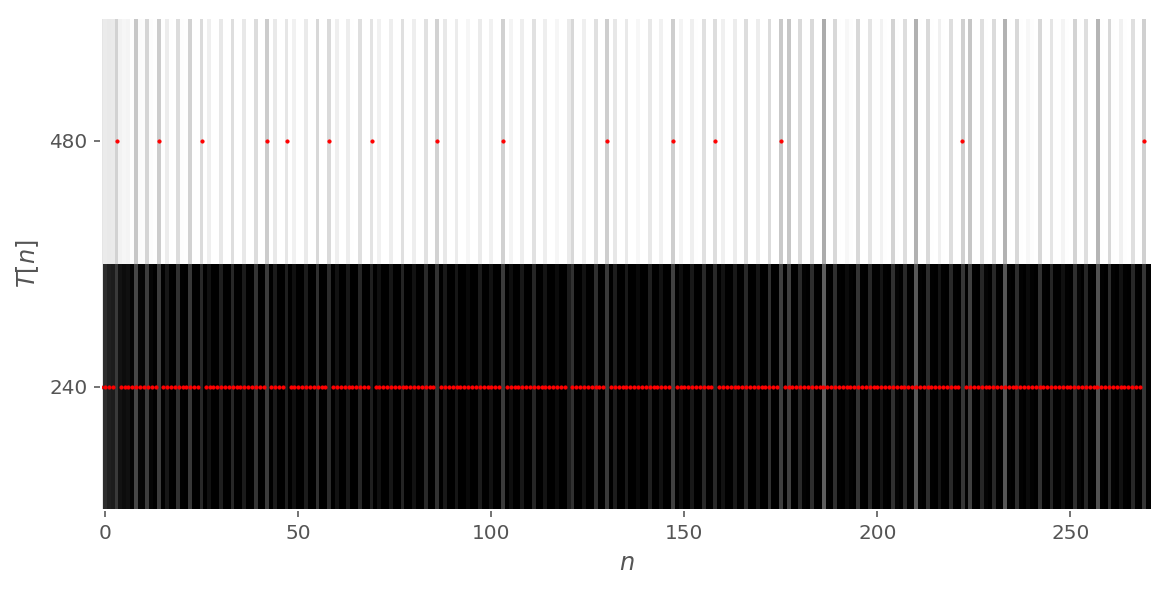

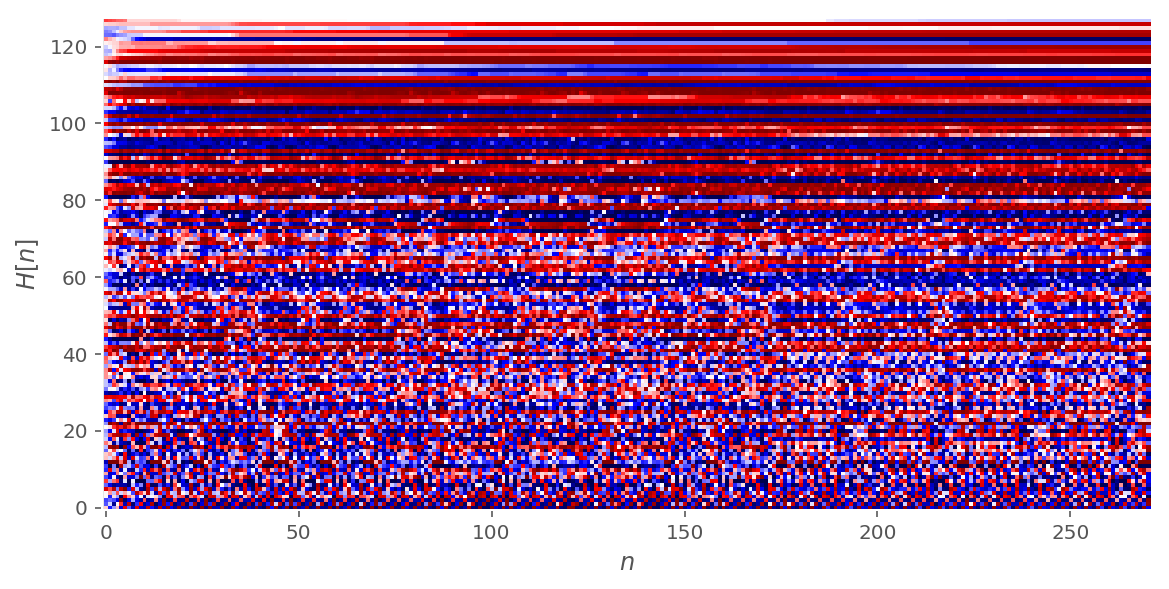

In [63]:
for i in range(4):
    print("Song # %i" % rnd_melodies[i])
    predT, predP = selected_model.predict([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:], 
                                           P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]])
    metrics = selected_model.evaluate([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:], 
                                        P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]],
                                      [T[rnd_melodies[i]:rnd_melodies[i]+1,1:,:], 
                                        P[rnd_melodies[i]:rnd_melodies[i]+1,1:,:]])
    print("YT accuracy on this song: %.4f" % metrics[3])
    print("YP accuracy on this song: %.4f" % metrics[4])
    H = modified_model.predict([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:],
                                         P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]])
    plotMelody(P[rnd_melodies[i]], T[rnd_melodies[i]], decoders, predP[0], predT[0], H[0])


Concerning the melodies, the red dots often appear on dark areas, which is a sign that our model is a good predictor. Concerning the hidden state dynamics, we will wait for a comparison baseline to say something useful. Let us then plot the hidden states for a simple RNN model:

In [64]:
# modified plot_melody function to plot only hidden states
def plot_hidden_states(H, maxn):
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:maxn-1,k], H[1:maxn,k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,maxn+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


Song # 2347
1/1 [==============================] - 0s 490ms/step
YT accuracy on this song: 0.6919
YP accuracy on this song: 0.3939


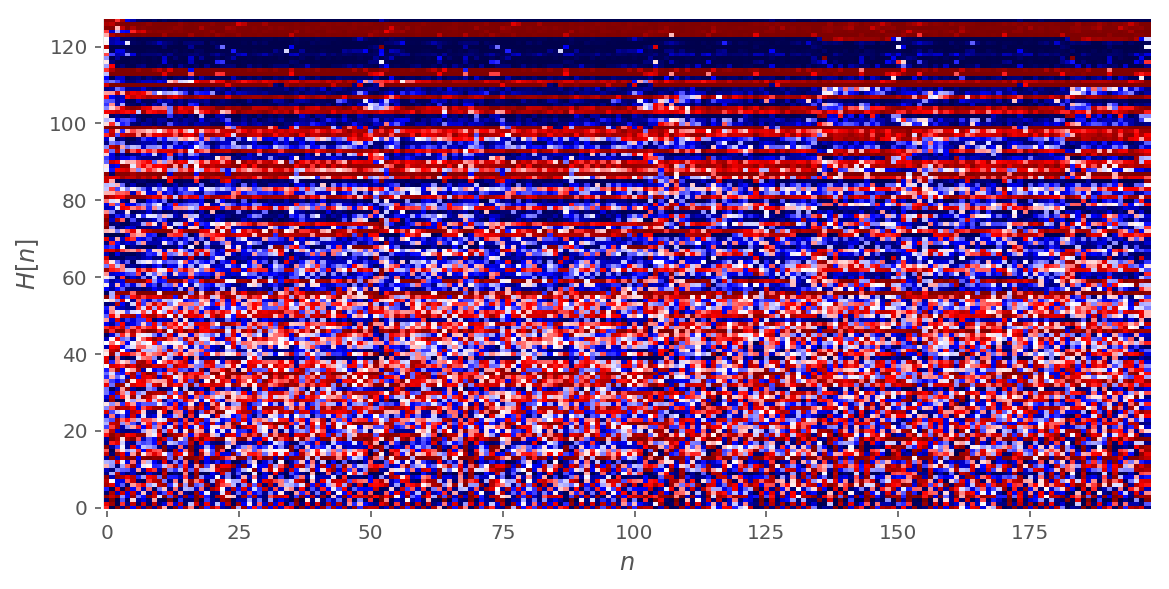

Song # 1516
1/1 [==============================] - 0s 21ms/step
YT accuracy on this song: 0.9396
YP accuracy on this song: 0.2418


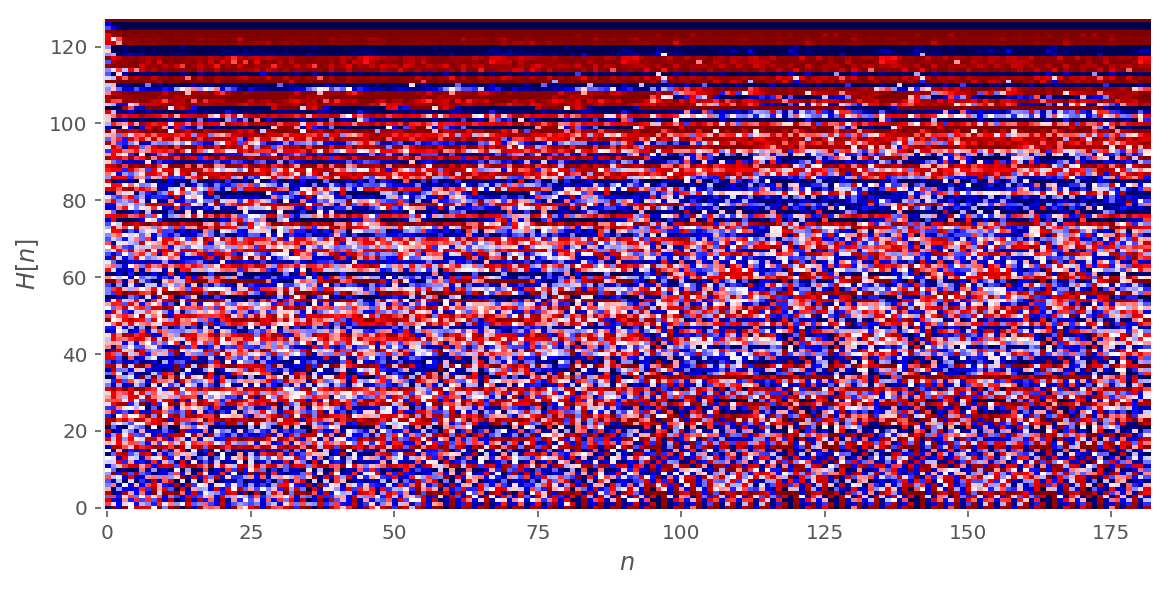

Song # 3713
1/1 [==============================] - 0s 20ms/step
YT accuracy on this song: 0.6190
YP accuracy on this song: 0.3333


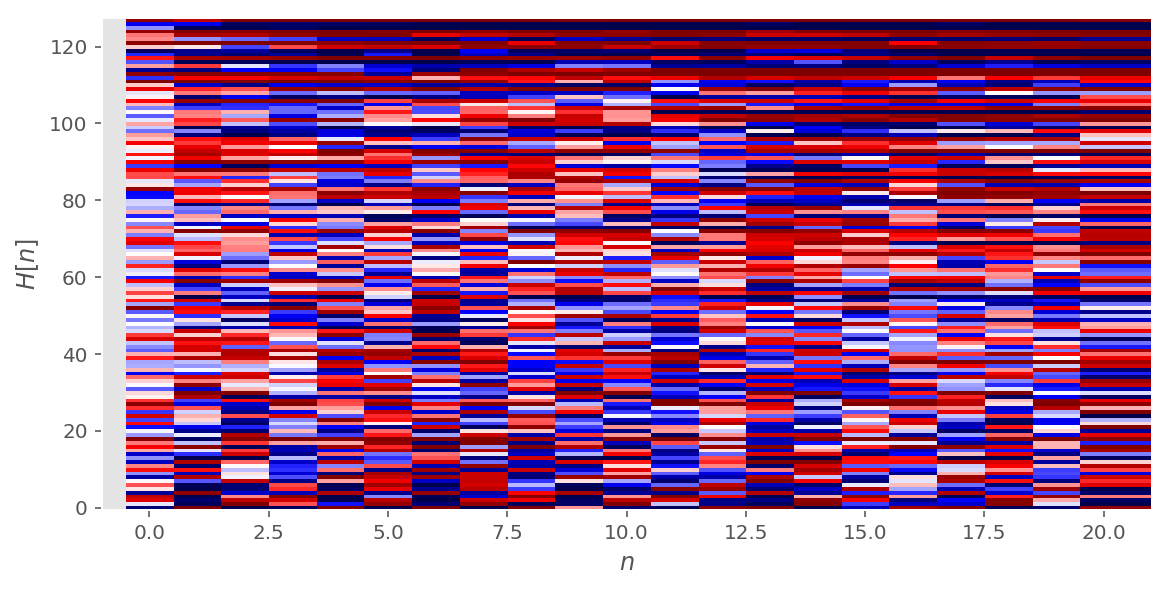

Song # 1045
1/1 [==============================] - 0s 20ms/step
YT accuracy on this song: 0.9410
YP accuracy on this song: 0.3173


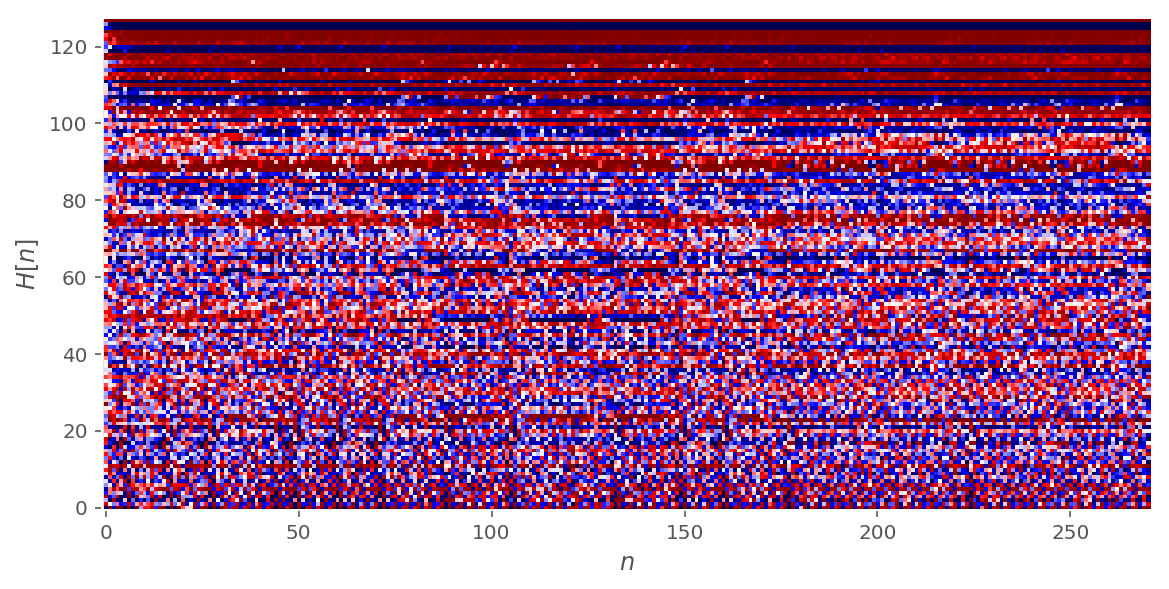

In [69]:
# Same for Simple RNN model
#sRNN_model = models['RNN-0.2']
sRNN_model = buildModel(decoders, T.shape[1]-1, dropout=0.1, activation='RNN')
sRNN_model.load_weights('RNN-0.2.bestYPacc.hdf5')
modified_RNN = build_modified_model(sRNN_model)

for i in range(4):
    print("Song # %i" % rnd_melodies[i])
    metrics = sRNN_model.evaluate([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:], 
                                        P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]],
                                      [T[rnd_melodies[i]:rnd_melodies[i]+1,1:,:], 
                                        P[rnd_melodies[i]:rnd_melodies[i]+1,1:,:]])
    print("YT accuracy on this song: %.4f" % metrics[3])
    print("YP accuracy on this song: %.4f" % metrics[4])
    H = modified_RNN.predict([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:],
                                         P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]])
    maxn = np.max(np.where(T[rnd_melodies[i]].sum(axis=-1) >= 1.))
    plot_hidden_states(H[0], maxn)

One can see that in the above plots the hidden state dynamics appear more unstable, especially in the upper part of the plots: we don't have so many long continous lines as for the GRUs. This can mean that the states change much more often. 

For completeness, let us also do the plots for LSTMs

Song # 2347
1/1 [==============================] - 1s 575ms/step
YT accuracy on this song: 0.7929
YP accuracy on this song: 0.4394


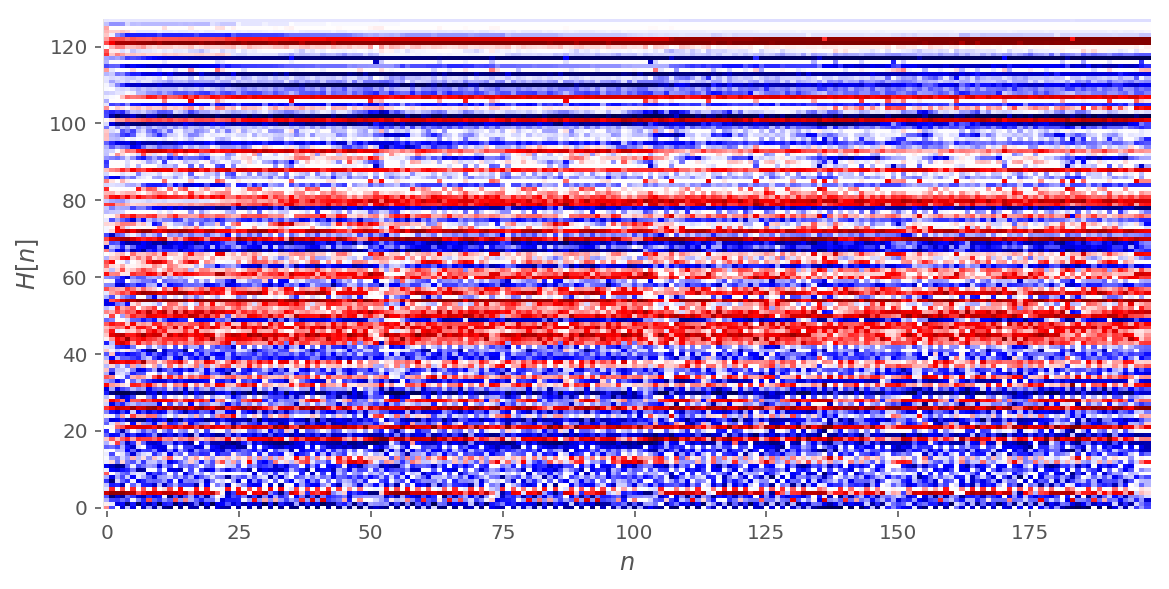

Song # 1516
1/1 [==============================] - 0s 42ms/step
YT accuracy on this song: 0.9451
YP accuracy on this song: 0.3736


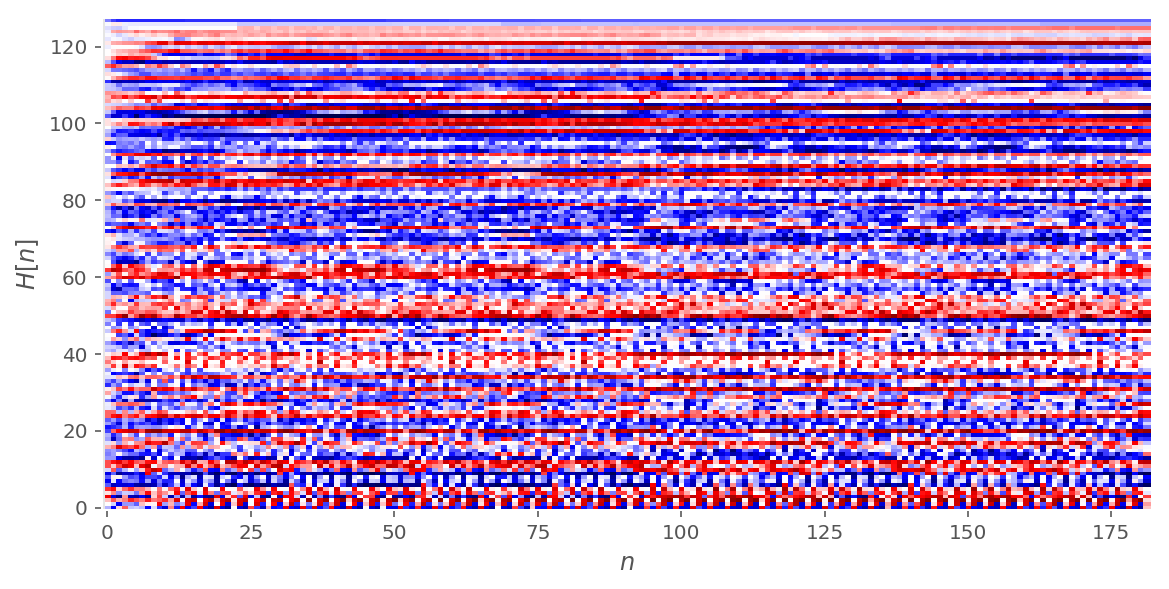

Song # 3713
1/1 [==============================] - 0s 38ms/step
YT accuracy on this song: 0.5238
YP accuracy on this song: 0.4762


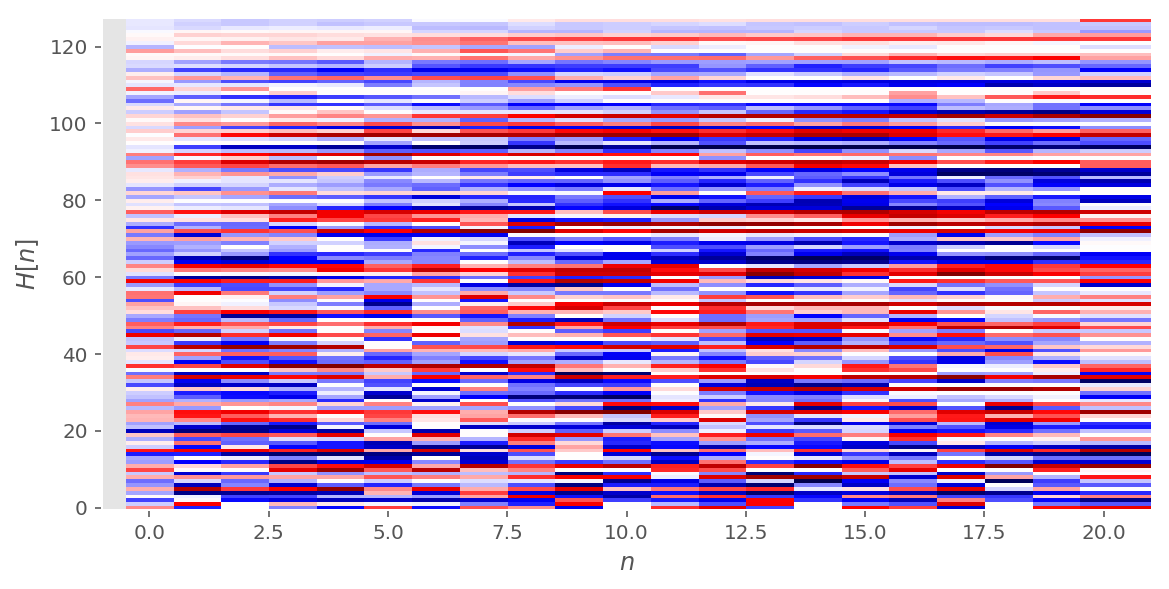

Song # 1045
1/1 [==============================] - 0s 40ms/step
YT accuracy on this song: 0.9446
YP accuracy on this song: 0.4982


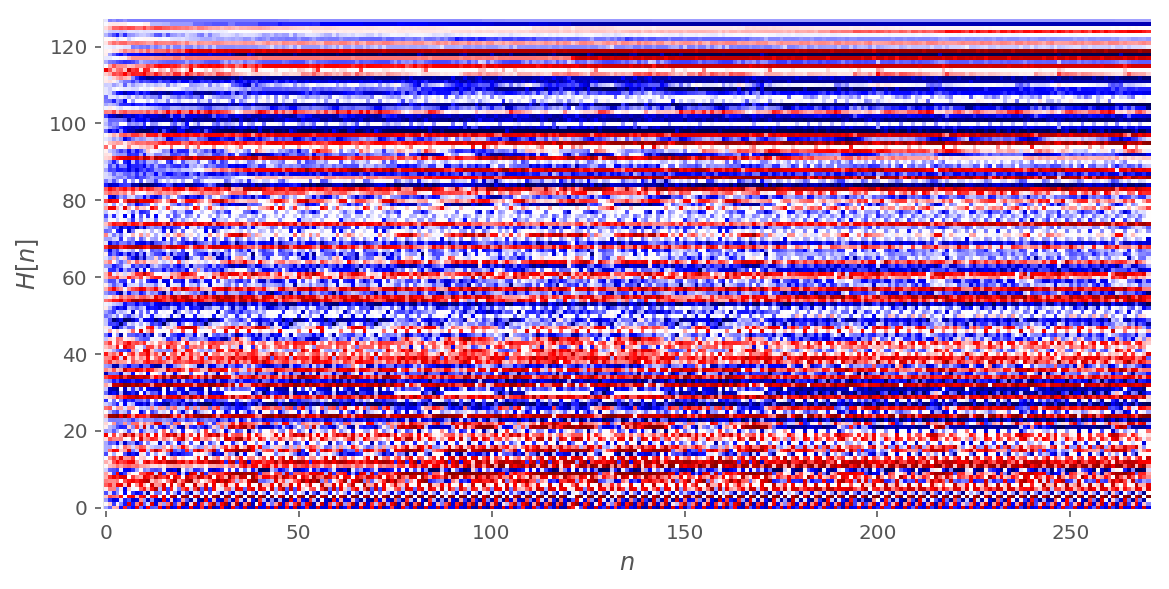

In [71]:
# For completeness, let's do this with LSTM
#LSTM_model = models['LSTM-0.2']
LSTM_model = buildModel(decoders, T.shape[1]-1, dropout=0.2, activation='LSTM')
LSTM_model.load_weights('LSTM-0.2.bestYPacc.hdf5')
modified_LSTM = build_modified_model(LSTM_model)

for i in range(4):
    print("Song # %i" % rnd_melodies[i])
    metrics = LSTM_model.evaluate([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:], 
                                        P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]],
                                      [T[rnd_melodies[i]:rnd_melodies[i]+1,1:,:], 
                                        P[rnd_melodies[i]:rnd_melodies[i]+1,1:,:]])
    print("YT accuracy on this song: %.4f" % metrics[3])
    print("YP accuracy on this song: %.4f" % metrics[4])
    H = modified_LSTM.predict([T[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:],
                                         P[rnd_melodies[i]:rnd_melodies[i]+1,:-1,:]])
    maxn = np.max(np.where(T[rnd_melodies[i]].sum(axis=-1) >= 1.))
    plot_hidden_states(H[0], maxn)

In [78]:
# computing mean activation changes for main model and simple RNN model
H = modified_model.predict([T[:,:-1,:],P[:,:-1,:]])
H_RNN = modified_RNN.predict([T[:,:-1,:],P[:,:-1,:]])
H_LSTM = modified_LSTM.predict([T[:,:-1,:],P[:,:-1,:]])

# compute deltas
dH = np.abs(np.diff(H, axis=1))
dH_RNN = np.abs(np.diff(H_RNN, axis=1))
dH_LSTM = np.abs(np.diff(H_LSTM, axis=1))

# flag masked timesteps
dH = np.where(np.dstack([np.sum(T[:,2:,:], axis=-1)]*128) > 0., dH, np.nan)
dH_RNN = np.where(np.dstack([np.sum(T[:,2:,:], axis=-1)]*128) > 0., dH_RNN, np.nan)
dH_LSTM = np.where(np.dstack([np.sum(T[:,2:,:], axis=-1)]*128) > 0., dH_LSTM, np.nan)

# compute means
mean_dH = np.nanmean(dH, axis=(0,1)).ravel()
mean_dH_RNN = np.nanmean(dH_RNN, axis=(0,1)).ravel()
mean_dH_LSTM = np.nanmean(dH_LSTM, axis=(0,1)).ravel()

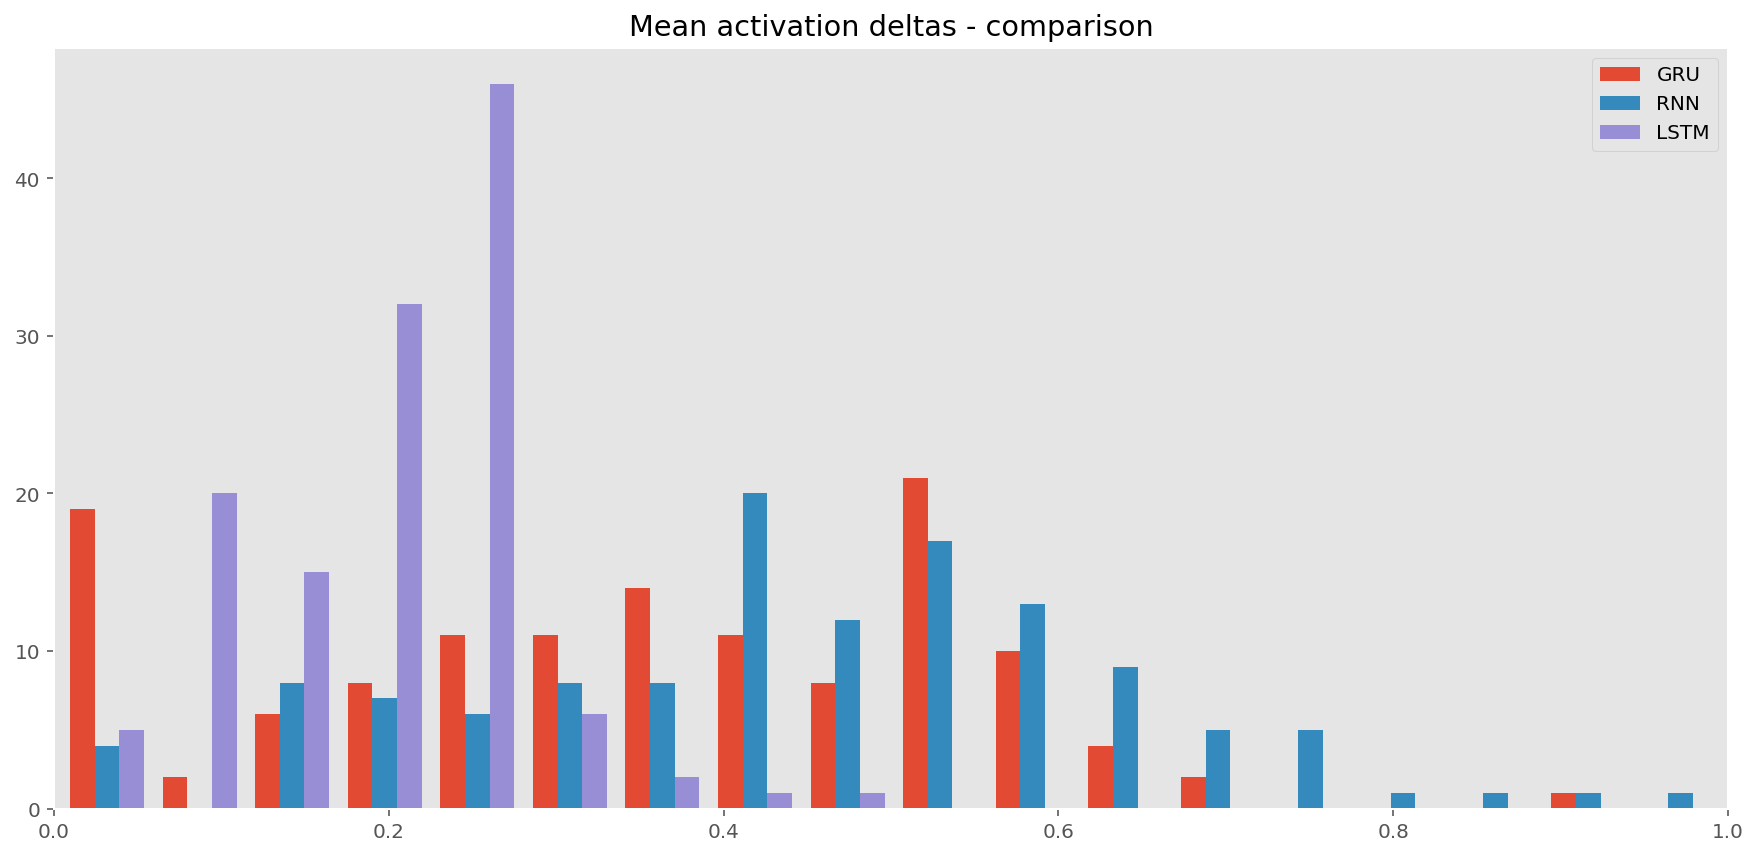

In [92]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist([mean_dH, mean_dH_RNN, mean_dH_LSTM], bins=20, label=['GRU', 'RNN', 'LSTM'])
ax.set_title("Mean activation deltas - comparison")
plt.xlim(0, 1.)
ax.legend()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 
The pattern underlined in the above graph is surprisingly clear: it appears that the values of $\Delta A_i$ are very concentrated around 0 for the LSTM model, less concentrated for the GRU models and even more spread for the RNN model. Theoretically, this can probably be linked to the gating capabilities of models: the fact that the input can be gated allows for the hidden state to be more stable (which is the same reason why these models are able to learn from long sequences). The LSTMs allow for a finer control of gates, which may be the reason why hidden states are even more stable.

## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [96]:
#GRU_model = models['GRU-0.2]
GRU_model = buildModel(decoders, T.shape[1] - 1, dropout=0.2, activation='GRU')
GRU_model.load_weights('GRU-0.2.bestYPacc.hdf5')
#RNN_model = models['RNN-0.2]
RNN_model = buildModel(decoders, T.shape[1] - 1, dropout=0.2, activation='RNN')
RNN_model.load_weights('RNN-0.2.bestYPacc.hdf5')

In [13]:
GRU_model.input_shape

[(None, 395, 17), (None, 395, 50)]

In [95]:
# Helper function to generate a melody
def generateMelody(model, filename, temperature = 1.0):
    initialPitch = np.random.randint(len(decoders['P']))
    initialTime = np.random.randint(len(decoders['T']))
    batch_length = model.input_shape[0][1]
    T, P = np.zeros((1, batch_length+1, model.input_shape[0][2])), np.zeros((1, batch_length+1, model.input_shape[1][2]))
    T[0, 0, initialTime] = 1
    P[0, 0, initialPitch] = 1
    #Probably a better way do do this
    for i in range(batch_length):
        predT, predP = model.predict([T[:,:-1,:], 
                                               P[:, :-1,:]])
        T[0, i+1,sample(predT[0,i], temperature)] = 1
        P[0, i+1,sample(predP[0,i], temperature)] = 1
    T = T[0, :, :]
    P = P[0, :, :]
    P = [np.argmax(P[i]) for i in range(P.shape[0])]
    T = [np.argmax(T[i]) for i in range(T.shape[0])]
    writeMIDI(P, T, decoders, filename)

In [16]:
for i in range(32):
    generateMelody(GRU_model, 'GRU_{}.mid'.format(i))
    generateMelody(RNN_model, 'RNN_{}.mid'.format(i))

In [21]:
print('GRU')
for i in np.random.choice(32, 4):
    music21.midi.translate.midiFilePathToStream('GRU_{}.mid'.format(i)).show('midi')

GRU


In [20]:
print('RNN')
for i in np.random.choice(32, 4):
    music21.midi.translate.midiFilePathToStream('RNN_{}.mid'.format(i)).show('midi')

RNN


In [61]:
def randomMelody(length, decoders, filename):
    T_range, P_range = len(decoders['T']), len(decoders['P'])
    T, P = np.zeros((length), dtype=int), np.zeros((length), dtype=int)
    for i in range(length):
        T[i] = np.random.randint(T_range)
        P[i] = np.random.randint(P_range)
    writeMIDI(P, T, decoders, filename)

In [6]:
randomMelody(395, decoders, 'random.mid')

In [7]:
print('Random')
music21.midi.translate.midiFilePathToStream('random.mid').show('midi')

Random


### Trying other temperatures

In [97]:
for temp in [0.4, 2.]:
    print('temperature: '+str(temp))
    generateMelody(GRU_model, 'GRU_theta{}.mid'.format(temp))
    music21.midi.translate.midiFilePathToStream('GRU_theta{}.mid'.format(temp)).show('midi')

temperature: 0.4


temperature: 2.0


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: With a temperature lower than one, one expects the more probable transitions to be chosen even more often (see the plot below to visualize the effect of temperature transform on the (0,1] interval). Indeed, when hearing a generated melody one can note little variability in notes and durations, with often long repetitions of the same note.

With a temperature higher than one, one expects more unlikely transitions to be sampled more often. Indeed, one hears a more unpredictable music with often weird transitions.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: Although the difference is not huge, the melodies generated by the GRU model seem to have better global coherence, with sometimes melodic patterns lasting over a dozen of notes and rythmic patterns that really sound irish. The RNN generated musics are not very coherent and usually don't have repetitions of patterns.



Text(0.5,1,'Effect of the temperature in sampling')

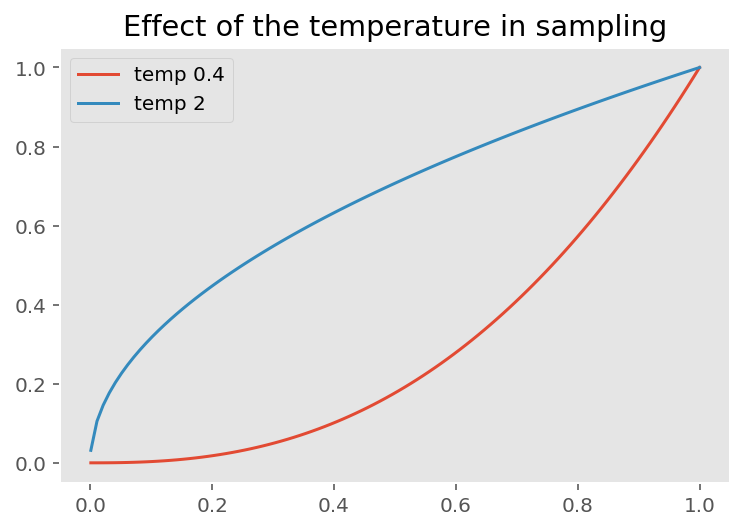

In [100]:
x = np.linspace(0.001, 1, 100)
y1 = np.exp(np.log(x)/0.4)
y2 = np.exp(np.log(x)/2.)
plt.plot(x, y1, label='temp 0.4')
plt.plot(x, y2, label = 'temp 2')
plt.legend()
plt.title("Effect of the temperature in sampling")